# Nino3.4 和 EAWM 指数计算

本notebook包含：
1. **Nino3.4指数计算**：基于ERA5 SST数据计算Nino3.4指数
2. **EAWM指数计算**：基于500hPa纬向风数据计算东亚冬季季风指数

两个指数都使用面积加权方法（cos(latitude)权重）进行空间平均，保持一致性。


In [21]:
# 导入必要的库
import sys
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from itertools import cycle
from scipy.stats import pearsonr
import re
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

# 添加工具包路径
# 添加工具包路径
# 使用绝对路径确保能找到文件
mmpe_dir = Path("/sas12t1/ffyan/MMPE")
toolkit_dir = Path("/sas12t1/ffyan/climate_analysis_toolkit")

sys.path.insert(0, str(toolkit_dir))
sys.path.insert(0, str(mmpe_dir))  # common_config在MMPE目录下
from common_config import CLIMATOLOGY_PERIOD, COLORS

print(f"CLIMATOLOGY_PERIOD: {CLIMATOLOGY_PERIOD}")
print(f"MMPE目录: {mmpe_dir}")
print(f"common_config.py存在: {(mmpe_dir / 'common_config.py').exists()}")


CLIMATOLOGY_PERIOD: 1993-2020
MMPE目录: /sas12t1/ffyan/MMPE
common_config.py存在: True


## 辅助函数定义


In [22]:
def area_weighted_mean(da: xr.DataArray, lat_name: str = 'lat') -> xr.DataArray:
    """
    计算面积加权平均（使用 cos(latitude) 权重）
    
    Args:
        da: 输入数据（需包含纬度维度）
        lat_name: 纬度坐标名
    
    Returns:
        面积加权空间平均后的数据
    """
    # 计算权重：cos(latitude in radians)
    weights = np.cos(np.deg2rad(da[lat_name]))
    
    # 对空间维度进行加权平均
    # 首先对经度求平均，然后对纬度加权平均
    if 'lon' in da.dims:
        # 先对经度求平均
        da_lon_mean = da.mean(dim='lon')
    else:
        da_lon_mean = da
    
    # 对纬度加权平均
    weighted_mean = (da_lon_mean * weights).sum(dim=lat_name) / weights.sum()
    
    return weighted_mean


def compute_monthly_anomaly(series: xr.DataArray, baseline: str = CLIMATOLOGY_PERIOD) -> Optional[xr.DataArray]:
    """
    计算逐月气候态异常
    
    Args:
        series: 时间序列数据 (time, ...)
        baseline: 气候态基期（如 "1993-2020"）
    
    Returns:
        月异常时间序列
    """
    # 解析基期
    start_year, end_year = baseline.split('-')
    start_year, end_year = int(start_year), int(end_year)
    
    print(f"计算逐月气候态异常，基期: {baseline}")
    
    # 选择基期数据
    clim_data = series.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))
    
    # 按月份分组计算气候态（12个月，每月的多年平均）
    climatology = clim_data.groupby('time.month').mean(dim='time')
    
    # 计算异常：原始值 - 对应月份的气候态
    anomaly = series.groupby('time.month') - climatology
    
    print(f"月异常计算完成: shape={anomaly.shape}")
    return anomaly


## 1. Nino3.4 指数计算


In [23]:
def load_era5_sst_daily(year_range: Tuple[int, int] = (1993, 2020),
                         era5_root: str = '/sas12t1/ffyan/ERA5/daily-nc/single-level/') -> Optional[xr.DataArray]:
    """
    从本地加载 ERA5 SST 日值数据
    
    Args:
        year_range: 年份范围，默认(1993, 2020)
        era5_root: ERA5 single-level 数据根目录
    
    Returns:
        日值数据 (time, latitude, longitude) 或 None
    """
    var_name = 'sst'
    var_dir = Path(era5_root) / var_name
    
    if not var_dir.exists():
        print(f"变量目录不存在: {var_dir}")
        return None
    
    print(f"从 ERA5 single-level 加载数据: {var_name}, 年份范围: {year_range}")
    
    start_year, end_year = year_range
    
    # 准备文件列表
    monthly_da_list = []
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            file_path = var_dir / f"era5_daily_{var_name}_{year}{month:02d}.nc"
            
            if not file_path.exists():
                continue
            
            try:
                ds = xr.open_dataset(file_path)
                
                if var_name not in ds:
                    ds.close()
                    continue
                
                da = ds[var_name]
                
                # 标准化坐标名（ERA5 使用 latitude/longitude）
                if 'latitude' in da.coords and 'lat' not in da.coords:
                    da = da.rename({'latitude': 'lat'})
                if 'longitude' in da.coords and 'lon' not in da.coords:
                    da = da.rename({'longitude': 'lon'})
                
                # 确保数据已加载
                da = da.load()
                ds.close()
                
                monthly_da_list.append(da)
                
            except Exception as e:
                print(f"加载文件失败 {year}{month:02d}: {e}")
                continue
    
    if not monthly_da_list:
        print(f"未找到数据: {var_name}, 年份范围: {year_range}")
        return None
    
    # 拼接所有月份数据
    data = xr.concat(monthly_da_list, dim='time')
    data = data.sortby('time')
    
    # 确保纬度是升序的（方便后续处理）
    if 'lat' in data.coords and data.lat.values[0] > data.lat.values[-1]:
        data = data.sortby('lat')
        print("纬度已排序为升序")
    
    print(f"ERA5 single-level 数据加载完成: {var_name}, shape={data.shape}")
    return data


def daily_to_monthly(da: xr.DataArray, var_name: str = 'sst') -> Optional[xr.DataArray]:
    """
    将日值数据聚合为月平均
    
    Args:
        da: 日值数据 (time, lat, lon)
        var_name: 变量名（用于选择聚合方法）
    
    Returns:
        月平均数据 (time, lat, lon)
    """
    print(f"将日值数据聚合为月平均: {var_name}")
    
    # 对于 SST、T2M 等温度变量，使用平均值
    monthly = da.resample(time='1MS').mean(dim='time')
    
    print(f"月聚合完成: shape={monthly.shape}")
    return monthly


In [24]:
def compute_nino34_index(sst_monthly: xr.DataArray = None, 
                         baseline: str = CLIMATOLOGY_PERIOD,
                         era5_root: str = '/sas12t1/ffyan/ERA5/daily-nc/single-level/',
                         year_range: Tuple[int, int] = (1993, 2020)) -> Optional[xr.DataArray]:
    """
    计算 Nino3.4 指数
    
    计算方法：
    1. 如果未提供 sst_monthly，从 ERA5 加载 SST 日值数据并聚合为月平均
    2. 裁剪到 Nino3.4 区域：5°N–5°S, 190°E–240°E
    3. 计算面积加权空间平均
    4. 计算逐月气候态异常
    
    Args:
        sst_monthly: 月平均 SST 数据（如已提供）
        baseline: 气候态基期
        era5_root: ERA5 数据根目录（如需加载）
        year_range: 年份范围（如需加载）
    
    Returns:
        Nino3.4 指数时间序列 (time,)
    """
    print("开始计算 Nino3.4 指数...")
    
    # 如果未提供月平均 SST，则加载并聚合
    if sst_monthly is None:
        print("加载 ERA5 SST 日值数据...")
        sst_daily = load_era5_sst_daily(year_range, era5_root)
        
        if sst_daily is None:
            print("SST 数据加载失败")
            return None
        
        print("聚合为月平均...")
        sst_monthly = daily_to_monthly(sst_daily, 'sst')
        
        if sst_monthly is None:
            print("月聚合失败")
            return None
    
    # Nino3.4 区域：5°N–5°S, 190°E–240°E
    print("裁剪到 Nino3.4 区域: 5°N–5°S, 190°E–240°E")
    
    # 数据已经在加载时标准化为 lat/lon 并排序为升序
    nino34_region = sst_monthly.sel(lat=slice(-5, 5), lon=slice(190, 240))
    
    if nino34_region.size == 0:
        print("Nino3.4 区域裁剪后无数据，请检查经纬度范围")
        return None
    
    # 计算面积加权空间平均
    print("计算面积加权空间平均...")
    nino34_spatial_mean = area_weighted_mean(nino34_region, lat_name='lat')
    
    # 计算逐月气候态异常
    print(f"计算逐月异常，基期: {baseline}")
    nino34_anomaly = compute_monthly_anomaly(nino34_spatial_mean, baseline)
    
    if nino34_anomaly is None:
        print("月异常计算失败")
        return None
    
    # 添加属性
    nino34_anomaly.attrs = {
        'long_name': 'Nino3.4 Index',
        'description': 'Sea surface temperature anomaly averaged over Nino3.4 region (5N-5S, 190E-240E)',
        'units': 'K',
        'region': '5N-5S, 190E-240E',
        'baseline_period': baseline,
        'data_source': 'ERA5 daily SST',
        'calculation_method': 'Area-weighted spatial mean (cos(lat) weighting) -> monthly anomaly'
    }
    
    print(f"Nino3.4 指数计算完成: {len(nino34_anomaly.time)} 个月")
    return nino34_anomaly


## 2. EAWM 指数计算


In [25]:
def compute_eawm_index(u_500: xr.DataArray) -> Optional[xr.DataArray]:
    """
    计算东亚冬季季风指数（I_EAWM）
    
    计算方法：
    1. 计算500hPa纬向风在两个区域的空间平均（使用面积加权，cos(lat)权重）：
       - 南区：25°–35°N, 80°–120°E
       - 北区：45°–55°N, 80°–120°E
    2. 计算区域平均后求差：I(t) = u_south(t) - u_north(t)
    3. 仅选择DJF季节数据（12、1、2月）
    4. 对DJF指数时间序列进行z-score标准化：I*(t) = (I(t) - μ) / σ
    
    注意：空间平均使用面积加权方法（cos(latitude)权重），与Nino3.4指数的计算方法保持一致。
    
    Args:
        u_500: 500hPa纬向风数据 (time, lat, lon) 或 (time, number, lat, lon)
    
    Returns:
        标准化的EAWM指数时间序列 (time,) 或 None
    """
    print("开始计算EAWM指数...")
    
    # 如果有number维度，先计算ensemble mean
    if 'number' in u_500.dims:
        u_500_mean = u_500.mean(dim='number')
        print("计算ensemble mean")
    else:
        u_500_mean = u_500
    
    # 定义两个区域
    south_region = {'lat': slice(25, 35), 'lon': slice(80, 120)}
    north_region = {'lat': slice(45, 55), 'lon': slice(80, 120)}
    
    # 计算两个区域的空间平均（使用面积加权，与Nino3.4指数保持一致）
    u_south_region = u_500_mean.sel(**south_region)
    u_north_region = u_500_mean.sel(**north_region)
    u_south = area_weighted_mean(u_south_region, lat_name='lat')
    u_north = area_weighted_mean(u_north_region, lat_name='lat')
    
    # 计算指数原型：I(t) = u_south(t) - u_north(t)
    index_raw = u_south - u_north
    
    print(f"原始指数时间序列长度: {len(index_raw.time)}")
    
    # 仅选择DJF季节（12、1、2月）
    djf_months = [12, 1, 2]
    index_djf = index_raw.sel(time=index_raw.time.dt.month.isin(djf_months))
    
    print(f"DJF指数时间序列长度: {len(index_djf.time)}")
    
    if len(index_djf.time) < 3:
        print("DJF数据不足，无法计算指数")
        return None
    
    # 对DJF指数时间序列进行z-score标准化
    index_values = index_djf.values
    valid_mask = ~np.isnan(index_values)
    
    if np.sum(valid_mask) < 3:
        print("有效DJF数据不足，无法标准化")
        return None
    
    index_mean = np.nanmean(index_values)
    index_std = np.nanstd(index_values)
    
    if index_std < 1e-10:
        print(f"指数标准差过小({index_std})，无法标准化")
        return None
    
    # 标准化：I*(t) = (I(t) - μ) / σ
    index_normalized = (index_values - index_mean) / index_std
    
    # 创建标准化后的DataArray
    index_result = xr.DataArray(
        index_normalized,
        coords={'time': index_djf.time},
        dims=['time'],
        name='eawm_index'
    )
    
    # 添加属性
    index_result.attrs = {
        'long_name': 'East Asian Winter Monsoon Index',
        'description': 'Standardized EAWM index: (u_south - u_north) at 500hPa, DJF only. Area-weighted spatial mean using cos(lat) weighting.',
        'south_region': '25-35N, 80-120E',
        'north_region': '45-55N, 80-120E',
        'season': 'DJF',
        'units': 'dimensionless (z-score)',
        'spatial_averaging_method': 'area-weighted (cos(lat) weighting)',
        'mean': float(index_mean),
        'std': float(index_std)
    }
    
    print(f"EAWM指数计算完成: 均值={index_mean:.3f}, 标准差={index_std:.3f}")
    return index_result


## 3. 使用示例

**注意**：本notebook会优先从已保存的文件加载数据（如果存在），这样可以避免重复计算。
- Nino3.4指数文件：`/sas12t1/ffyan/output/circulation_analysis/results/circulation_nino34_era5.nc`
- EAWM指数文件：`/sas12t1/ffyan/output/circulation_analysis/results/circulation_obs_eawm_index.nc`

如果文件不存在，则会自动进行计算。


In [26]:
# 计算或加载 Nino3.4 指数
# 首先尝试从已保存的文件加载
output_dir = Path('/sas12t1/ffyan/output/circulation_analysis/results')
nino34_file = output_dir / "circulation_nino34_era5.nc"

if nino34_file.exists():
    print(f"从文件加载 Nino3.4 指数: {nino34_file}")
    try:
        # 打开文件并立即加载数据，然后关闭
        da = xr.open_dataarray(nino34_file)
        nino34_index = da.load()
        da.close()  # 确保文件关闭
        print("Nino3.4 指数加载成功")
    except Exception as e:
        print(f"加载文件失败: {e}")
        print("将重新计算 Nino3.4 指数...")
        nino34_index = compute_nino34_index(
            year_range=(1993, 2020),
            era5_root='/sas12t1/ffyan/ERA5/daily-nc/single-level/'
        )
else:
    print("文件不存在，开始计算 Nino3.4 指数...")
    nino34_index = compute_nino34_index(
        year_range=(1993, 2020),
        era5_root='/sas12t1/ffyan/ERA5/daily-nc/single-level/'
    )

if nino34_index is not None:
    print(f"\nNino3.4 指数统计信息:")
    print(f"  时间范围: {nino34_index.time.values[0]} 到 {nino34_index.time.values[-1]}")
    print(f"  数据点数: {len(nino34_index.time)}")
    print(f"  均值: {nino34_index.values.mean():.4f} K")
    print(f"  标准差: {nino34_index.values.std():.4f} K")
    print(f"  最小值: {nino34_index.values.min():.4f} K")
    print(f"  最大值: {nino34_index.values.max():.4f} K")


从文件加载 Nino3.4 指数: /sas12t1/ffyan/output/circulation_analysis/results/circulation_nino34_era5.nc
Nino3.4 指数加载成功

Nino3.4 指数统计信息:
  时间范围: 1993-01-01T00:00:00.000000000 到 2020-12-01T00:00:00.000000000
  数据点数: 336
  均值: -0.0000 K
  标准差: 0.8946 K
  最小值: -1.9187 K
  最大值: 2.8706 K


In [27]:
# 加载 EAWM 指数（从已保存的文件）
# EAWM指数现在以CSV格式存储，包含多个数据集和leadtime
# 这里加载ERA5的数据作为主要的eawm_index（用于后续分析）
csv_file = output_dir / "circulation_eawm_index.csv"
eawm_index = None

if csv_file.exists():
    print(f"从CSV文件加载 EAWM 指数: {csv_file}")
    try:
        # 读取CSV文件
        df = pd.read_csv(csv_file, index_col='DJF_Year')
        
        # 提取ERA5列（观测数据）
        if 'ERA5' in df.columns:
            era5_values = df['ERA5'].values
            years = df.index.values
            
            # 转换为xarray DataArray格式（保持与后续代码兼容）
            # 将年份转换为时间索引（使用12月作为月份，因为DJF年份代表该年的冬季）
            times = pd.to_datetime([f'{int(year)}-12-15' for year in years])
            
            eawm_index = xr.DataArray(
                era5_values,
                dims=['time'],
                coords={'time': times},
                name='eawm_index',
                attrs={
                    'description': 'Standardized EAWM index (ERA5) from CSV file',
                    'source': 'circulation_eawm_index.csv',
                    'variable': 'ERA5'
                }
            )
            
            print("EAWM 指数（ERA5）加载成功")
            
            # 显示统计信息
            print(f"\nEAWM 指数统计信息:")
            print(f"  时间范围: {years[0]} 到 {years[-1]}")
            print(f"  数据点数: {len(years)}")
            print(f"  均值: {eawm_index.values.mean():.4f}")
            print(f"  标准差: {eawm_index.values.std():.4f}")
            print(f"  最小值: {eawm_index.values.min():.4f}")
            print(f"  最大值: {eawm_index.values.max():.4f}")
            
            # 显示CSV文件中可用的其他数据集
            other_datasets = [col for col in df.columns if col != 'ERA5']
            if other_datasets:
                print(f"\nCSV文件中还包含以下数据集: {', '.join(other_datasets[:5])}")
                if len(other_datasets) > 5:
                    print(f"  ... 共 {len(other_datasets)} 个数据集")
        else:
            print("警告：CSV文件中没有找到'ERA5'列")
            print(f"可用的列: {list(df.columns)}")
    except Exception as e:
        print(f"加载CSV文件失败: {e}")
        import traceback
        traceback.print_exc()
        eawm_index = None
else:
    print("EAWM指数CSV文件不存在")
    print(f"预期文件路径: {csv_file}")
    print("如果需要重新计算，需要先加载500hPa纬向风数据")
    print("可以从ERA5加载：")
    print("  obs_dir = Path('/sas12t1/ffyan/ERA5/monthly-nc/pressure-levels/')")
    print("  # 然后加载u变量在500hPa的数据")


从CSV文件加载 EAWM 指数: /sas12t1/ffyan/output/circulation_analysis/results/circulation_eawm_index.csv
EAWM 指数（ERA5）加载成功

EAWM 指数统计信息:
  时间范围: 1994 到 2016
  数据点数: 23
  均值: -0.0880
  标准差: 0.6806
  最小值: -1.8104
  最大值: 1.5037

CSV文件中还包含以下数据集: CMCC-35_L0, CMCC-35_L1, CMCC-35_L2, CMCC-35_L3, CMCC-35_L4
  ... 共 42 个数据集


## 4. 可视化


时间序列图已保存: /sas12t1/ffyan/output/circulation_analysis/plots/circulation_nino34_timeseries.png


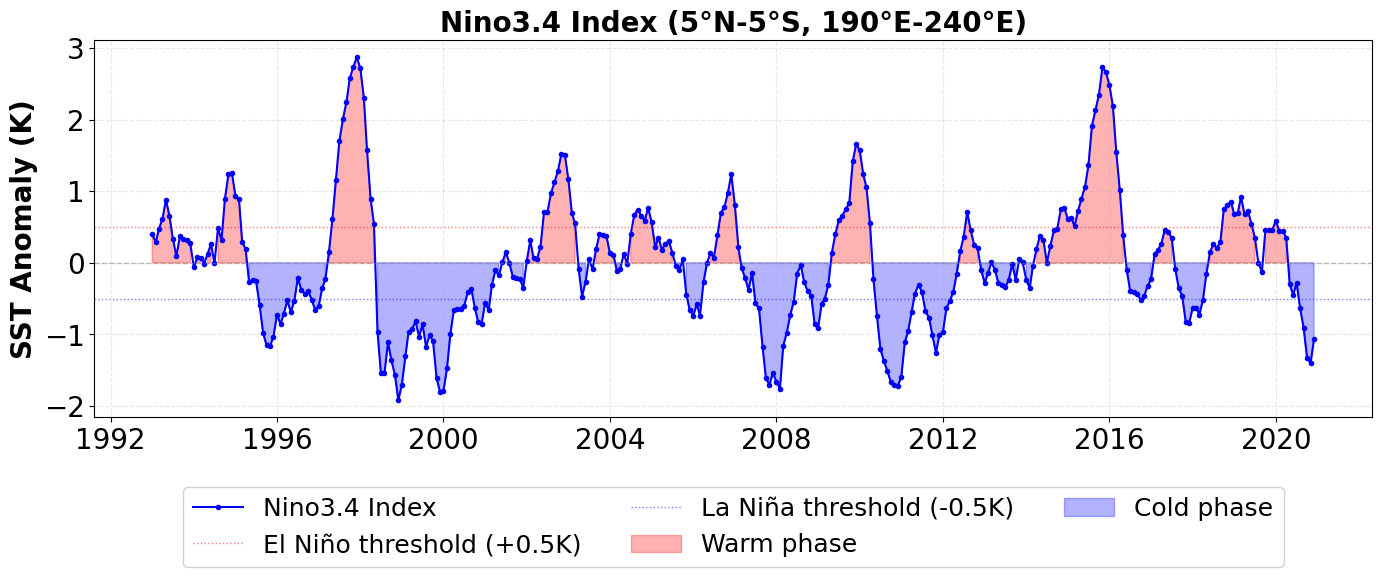

In [46]:
# 绘制 Nino3.4 指数时间序列（参考circulation_analysis.py）
if nino34_index is not None:
    plots_dir = Path('/sas12t1/ffyan/output/circulation_analysis/plots')
    plots_dir.mkdir(parents=True, exist_ok=True)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # 绘制 Nino3.4 指数
    ax.plot(nino34_index.time.values, nino34_index.values, 
            color='blue', linewidth=1.5, marker='o', markersize=3,
            label='Nino3.4 Index')
    
    # 添加零线
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # 标记 El Niño 和 La Niña 事件（使用常见的阈值 ±0.5K）
    ax.axhline(y=0.5, color='red', linestyle=':', linewidth=1, alpha=0.5, label='El Niño threshold (+0.5K)')
    ax.axhline(y=-0.5, color='blue', linestyle=':', linewidth=1, alpha=0.5, label='La Niña threshold (-0.5K)')
    
    # 填充区域
    ax.fill_between(nino34_index.time.values, 0, nino34_index.values,
                    where=(nino34_index.values > 0), 
                    alpha=0.3, color='red', label='Warm phase')
    ax.fill_between(nino34_index.time.values, 0, nino34_index.values,
                    where=(nino34_index.values < 0), 
                    alpha=0.3, color='blue', label='Cold phase')
    
    # 设置标签
    ax.tick_params(axis='x', labelsize=20)  # 设置x轴刻度字体大小
    ax.tick_params(axis='y', labelsize=20)  # 设置y轴刻度字体大小
    # ax.set_xlabel('Time', fontsize=20, fontweight='bold')
    ax.set_ylabel('SST Anomaly (K)', fontsize=20, fontweight='bold')
    ax.set_title('Nino3.4 Index (5°N-5°S, 190°E-240°E)', fontsize=20, fontweight='bold')
    
    # 设置网格
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # 设置图例
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
             ncol=3, fontsize=18, framealpha=0.9)
    
    # 调整布局
    plt.tight_layout()
    
    # 保存图像
    output_file_png = plots_dir / "circulation_nino34_timeseries.png"
    output_file_pdf = plots_dir / "circulation_nino34_timeseries.pdf"
    plt.savefig(output_file_png, dpi=300, bbox_inches='tight')
    plt.savefig(output_file_pdf, format='pdf', bbox_inches='tight')
    print(f"时间序列图已保存: {output_file_png}")
    
    plt.show()
else:
    print("Nino3.4 指数数据不可用，无法绘图")


从CSV文件读取EAWM指数数据: /sas12t1/ffyan/output/circulation_analysis/results/circulation_eawm_index.csv
从CSV读取数据，年份范围: 1994 - 2016
时间序列图已保存: /sas12t1/ffyan/output/circulation_analysis/plots/circulation_eawm_index_timeseries.png


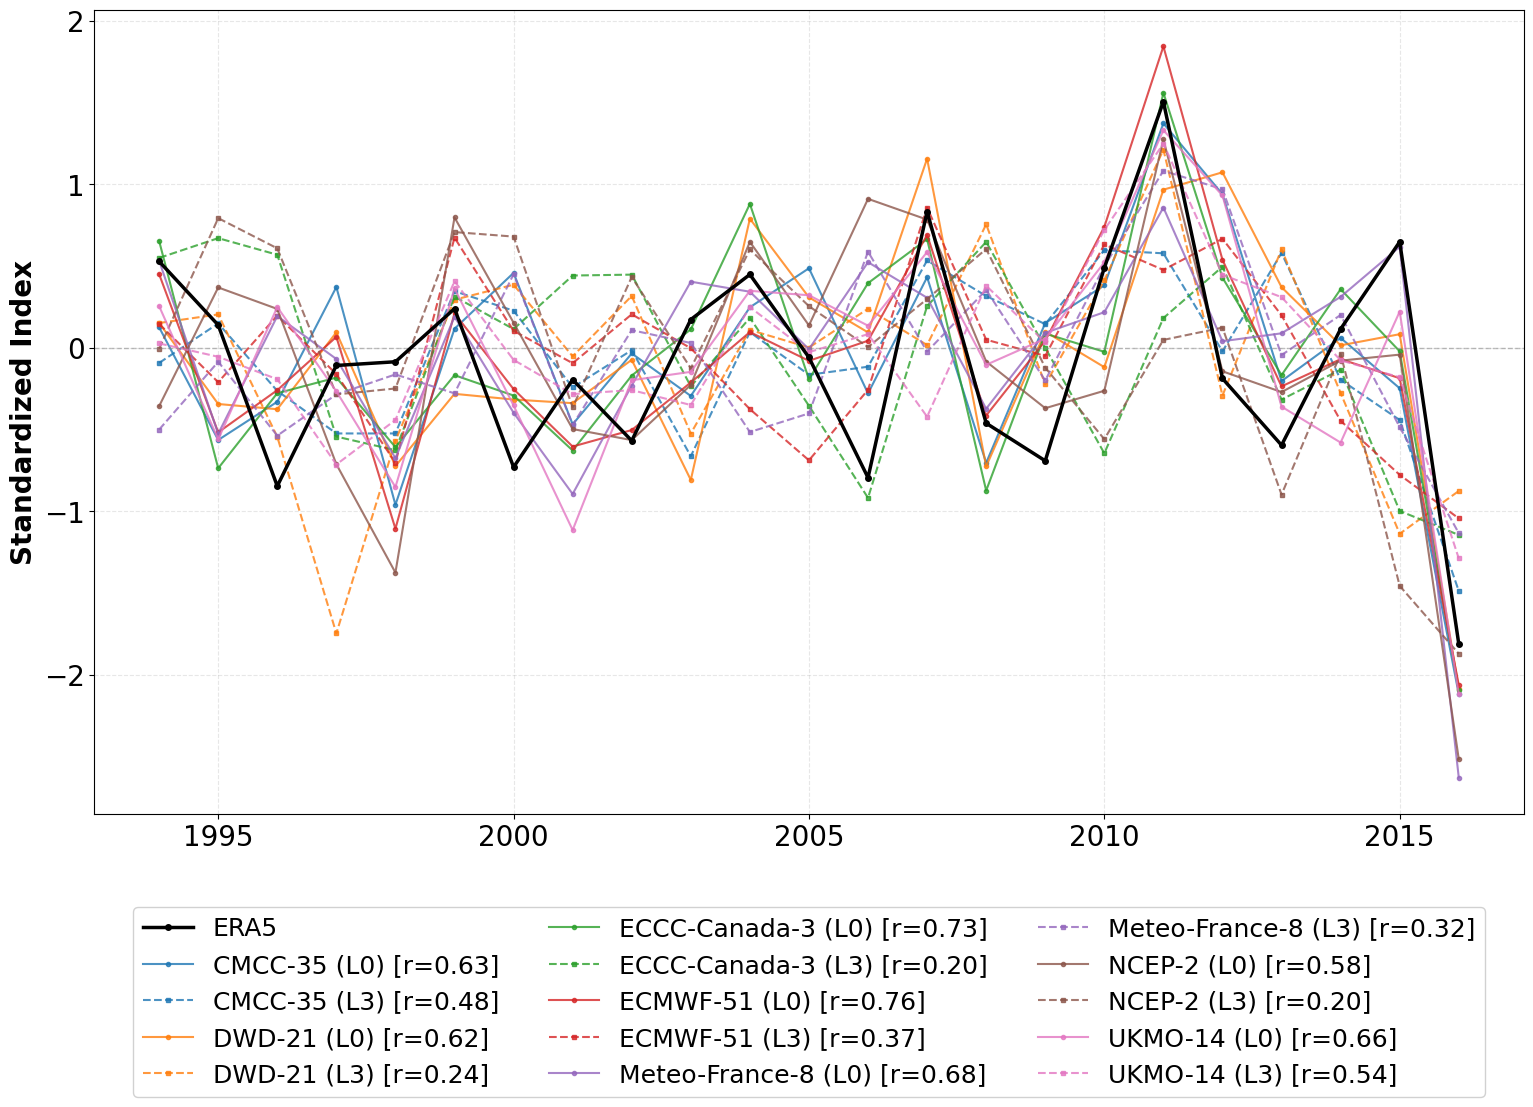

绘制multi-model mean和spread...
Multi-model mean图已保存: /sas12t1/ffyan/output/circulation_analysis/plots/circulation_eawm_index_mmm.png


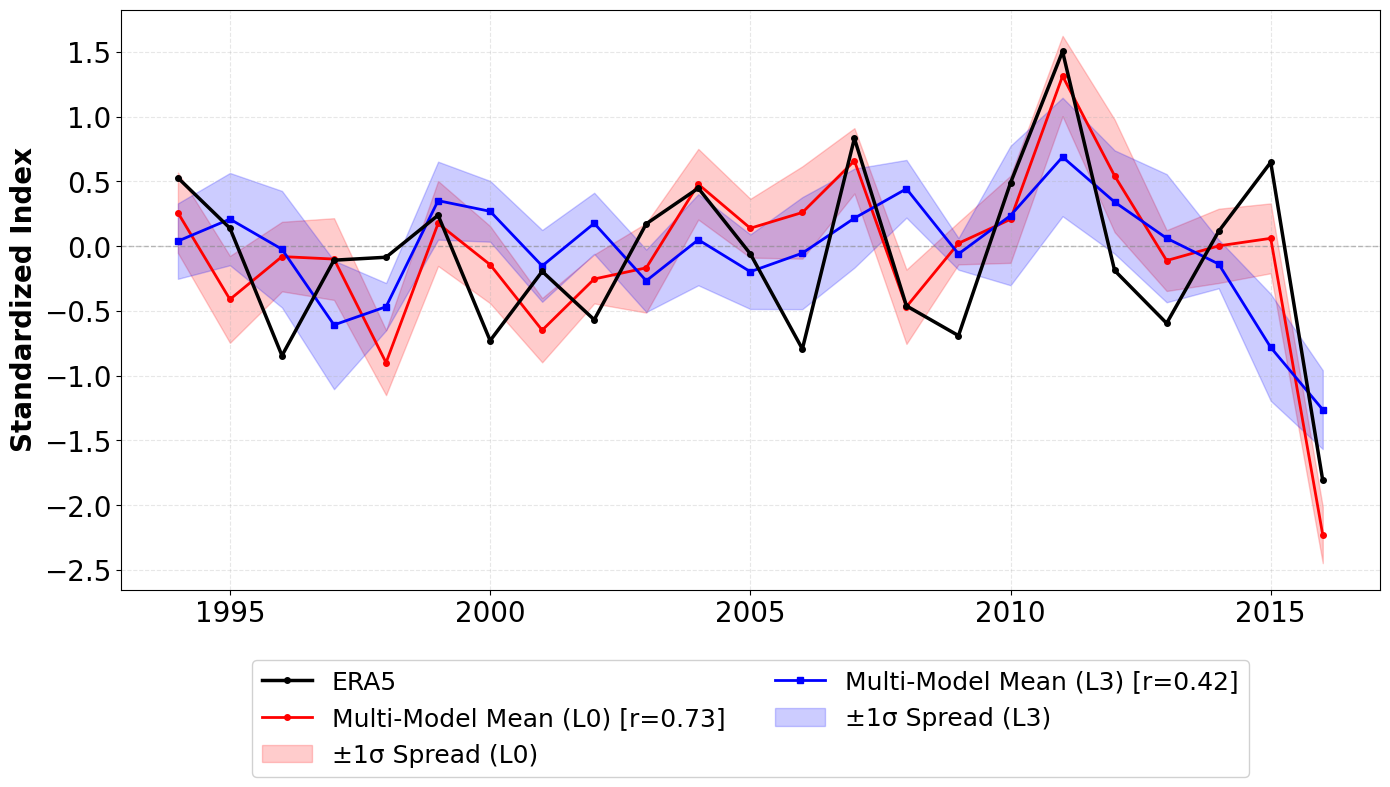

In [52]:
# 绘制 EAWM 指数时间序列（参考circulation_analysis.py）
# 注意：EAWM指数绘图需要从CSV文件读取所有模型的数据
plots_dir = Path('/sas12t1/ffyan/output/circulation_analysis/plots')
plots_dir.mkdir(parents=True, exist_ok=True)

csv_file = Path('/sas12t1/ffyan/output/circulation_analysis/results/circulation_eawm_index.csv')

if csv_file.exists():
    print(f"从CSV文件读取EAWM指数数据: {csv_file}")
    df = pd.read_csv(csv_file, index_col='DJF_Year')
    years = df.index.values
    
    print(f"从CSV读取数据，年份范围: {years[0]} - {years[-1]}")
    
    # 按leadtime分组数据
    plot_data_by_leadtime = {'L0': {}, 'L3': {}}
    
    # 从DataFrame中提取数据
    for col in df.columns:
        if '_L0' in col:
            leadtime = 'L0'
            base_model = col.replace('_L0', '')
        elif '_L3' in col:
            leadtime = 'L3'
            base_model = col.replace('_L3', '')
        elif col == 'ERA5':
            # ERA5在两个leadtime图中都显示
            base_model = 'ERA5'
            era5_values = df[col].values
            plot_data_by_leadtime['L0']['ERA5'] = {'years': years, 'values': era5_values}
            plot_data_by_leadtime['L3']['ERA5'] = {'years': years, 'values': era5_values}
            continue
        else:
            continue  # 跳过其他leadtime
        
        # 获取数据值
        values = df[col].values
        
        # 只保留有效数据（非NaN）的年份
        valid_mask = ~np.isnan(values)
        valid_years = years[valid_mask]
        valid_values = values[valid_mask]
        
        if len(valid_years) > 0:
            plot_data_by_leadtime[leadtime][base_model] = {
                'years': valid_years,
                'values': valid_values
            }
    
    # ========== 1. 绘制时间序列图（L0和L3在同一图中）==========
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # 获取ERA5数据
    era5_years = None
    era5_values = None
    if 'ERA5' in plot_data_by_leadtime['L0']:
        era5_data = plot_data_by_leadtime['L0']['ERA5']
        era5_years = era5_data['years']
        era5_values = era5_data['values']
        ax.plot(era5_years, era5_values, 
               color='black', linewidth=2.5, marker='o', markersize=4,
               label='ERA5', zorder=10)
    
    # 获取模型列表
    model_names_l0 = [name for name in plot_data_by_leadtime['L0'].keys() if name != 'ERA5']
    model_names_l3 = [name for name in plot_data_by_leadtime['L3'].keys() if name != 'ERA5']
    all_model_names = sorted(list(set(model_names_l0 + model_names_l3)))
    
    # 为每个模型分配一个基础颜色
    model_colors = {}
    colors_iter = cycle(COLORS)
    for model_name in all_model_names:
        model_colors[model_name] = next(colors_iter)
    
    # 按模型分组绘制，每个模型先画L0再画L3
    for model_name in sorted(all_model_names):
        # 绘制L0数据（如果有）
        if model_name in plot_data_by_leadtime['L0']:
            model_data = plot_data_by_leadtime['L0'][model_name]
            color = model_colors[model_name]
            display_name = model_name.replace('-mon', '').replace('mon-', '')
            
            # 计算与ERA5的相关系数（在共同年份上）
            corr_str = ''
            if era5_years is not None and era5_values is not None:
                # 找到共同年份
                common_years = np.intersect1d(era5_years, model_data['years'])
                if len(common_years) > 2:
                    era5_common = np.array([era5_values[np.where(era5_years == y)[0][0]] for y in common_years])
                    model_common = np.array([model_data['values'][np.where(model_data['years'] == y)[0][0]] for y in common_years])
                    try:
                        corr, _ = pearsonr(era5_common, model_common)
                        corr_str = f' [r={corr:.2f}]'
                    except:
                        pass
            
            ax.plot(model_data['years'], model_data['values'],
                   color=color, linewidth=1.5, linestyle='-', marker='o', markersize=3,
                   label=f'{display_name} (L0){corr_str}', alpha=0.8)
        
        # 绘制L3数据（如果有）
        if model_name in plot_data_by_leadtime['L3']:
            model_data = plot_data_by_leadtime['L3'][model_name]
            color = model_colors[model_name]
            display_name = model_name.replace('-mon', '').replace('mon-', '')
            
            # 计算与ERA5的相关系数（在共同年份上）
            corr_str = ''
            if era5_years is not None and era5_values is not None:
                # 找到共同年份
                common_years = np.intersect1d(era5_years, model_data['years'])
                if len(common_years) > 2:
                    era5_common = np.array([era5_values[np.where(era5_years == y)[0][0]] for y in common_years])
                    model_common = np.array([model_data['values'][np.where(model_data['years'] == y)[0][0]] for y in common_years])
                    try:
                        corr, _ = pearsonr(era5_common, model_common)
                        corr_str = f' [r={corr:.2f}]'
                    except:
                        pass
            
            ax.plot(model_data['years'], model_data['values'],
                   color=color, linewidth=1.5, linestyle='--', marker='s', markersize=3,
                   label=f'{display_name} (L3){corr_str}', alpha=0.8)
    
    # 添加零线
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    # 设置标签
    ax.tick_params(axis='x', labelsize=20)  # 设置x轴刻度字体大小
    ax.tick_params(axis='y', labelsize=20)  # 设置y轴刻度字体大小
    ax.set_ylabel('Standardized Index', fontsize=20, fontweight='bold')
    
    # 设置网格
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # 设置图例：放在图外下方，横向排列
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), 
             ncol=3, fontsize=18, framealpha=0.9)
    
    # 调整布局，为底部图例留出空间
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.18)
    
    # 保存图像
    output_file_png = plots_dir / "circulation_eawm_index_timeseries.png"
    output_file_pdf = plots_dir / "circulation_eawm_index_timeseries.pdf"
    plt.savefig(output_file_png, dpi=300, bbox_inches='tight')
    plt.savefig(output_file_pdf, format='pdf', bbox_inches='tight')
    print(f"时间序列图已保存: {output_file_png}")
    
    plt.show()
    
    # ========== 2. 绘制Multi-Model Mean和Spread图（L0和L3在同一图中）==========
    if len(model_names_l0) > 1 or len(model_names_l3) > 1:
        print("绘制multi-model mean和spread...")
        
        fig, ax = plt.subplots(figsize=(14, 7))
        
        # 获取ERA5数据用于计算相关系数
        era5_years_mmm = None
        era5_values_mmm = None
        if 'ERA5' in plot_data_by_leadtime['L0']:
            era5_data = plot_data_by_leadtime['L0']['ERA5']
            era5_years_mmm = era5_data['years']
            era5_values_mmm = era5_data['values']
            ax.plot(era5_years_mmm, era5_values_mmm,
                   color='black', linewidth=2.5, marker='o', markersize=4,
                   label='ERA5', zorder=10)
        
        # 处理L0的multi-model mean
        if len(model_names_l0) > 1:
            # 找到L0共同年份
            common_years_l0 = None
            for model_name in model_names_l0:
                years = plot_data_by_leadtime['L0'][model_name]['years']
                if common_years_l0 is None:
                    common_years_l0 = set(years)
                else:
                    common_years_l0 = common_years_l0.intersection(set(years))
            
            if common_years_l0 and len(common_years_l0) > 0:
                common_years_l0 = sorted(list(common_years_l0))
                
                # 收集所有模型在共同年份的值
                model_values_by_year_l0 = {year: [] for year in common_years_l0}
                for model_name in model_names_l0:
                    model_data = plot_data_by_leadtime['L0'][model_name]
                    year_to_value = dict(zip(model_data['years'], model_data['values']))
                    for year in common_years_l0:
                        if year in year_to_value:
                            model_values_by_year_l0[year].append(year_to_value[year])
                
                # 计算multi-model mean和std
                mm_mean_l0 = []
                mm_std_l0 = []
                for year in common_years_l0:
                    values = model_values_by_year_l0[year]
                    if len(values) > 0:
                        mm_mean_l0.append(np.mean(values))
                        mm_std_l0.append(np.std(values))
                    else:
                        mm_mean_l0.append(np.nan)
                        mm_std_l0.append(np.nan)
                
                mm_mean_l0 = np.array(mm_mean_l0)
                mm_std_l0 = np.array(mm_std_l0)
                
                # 计算L0 MMM与ERA5的相关系数
                corr_l0_str = ''
                if era5_years_mmm is not None and era5_values_mmm is not None:
                    common_years_era5_l0 = np.intersect1d(era5_years_mmm, common_years_l0)
                    if len(common_years_era5_l0) > 2:
                        era5_common = np.array([era5_values_mmm[np.where(era5_years_mmm == y)[0][0]] for y in common_years_era5_l0])
                        mmm_common = np.array([mm_mean_l0[np.where(np.array(common_years_l0) == y)[0][0]] for y in common_years_era5_l0])
                        try:
                            corr, _ = pearsonr(era5_common, mmm_common)
                            corr_l0_str = f' [r={corr:.2f}]'
                        except:
                            pass
                
                # 绘制L0 multi-model mean（红色实线）
                ax.plot(common_years_l0, mm_mean_l0,
                       color='red', linewidth=2, linestyle='-', marker='o', markersize=4,
                       label=f'Multi-Model Mean (L0){corr_l0_str}', zorder=5)
                
                # 绘制L0 ±1σ spread（红色填充）
                ax.fill_between(common_years_l0, mm_mean_l0 - mm_std_l0, mm_mean_l0 + mm_std_l0,
                               color='red', alpha=0.2, label='±1σ Spread (L0)')
        
        # 处理L3的multi-model mean
        if len(model_names_l3) > 1:
            # 找到L3共同年份
            common_years_l3 = None
            for model_name in model_names_l3:
                years = plot_data_by_leadtime['L3'][model_name]['years']
                if common_years_l3 is None:
                    common_years_l3 = set(years)
                else:
                    common_years_l3 = common_years_l3.intersection(set(years))
            
            if common_years_l3 and len(common_years_l3) > 0:
                common_years_l3 = sorted(list(common_years_l3))
                
                # 收集所有模型在共同年份的值
                model_values_by_year_l3 = {year: [] for year in common_years_l3}
                for model_name in model_names_l3:
                    model_data = plot_data_by_leadtime['L3'][model_name]
                    year_to_value = dict(zip(model_data['years'], model_data['values']))
                    for year in common_years_l3:
                        if year in year_to_value:
                            model_values_by_year_l3[year].append(year_to_value[year])
                
                # 计算multi-model mean和std
                mm_mean_l3 = []
                mm_std_l3 = []
                for year in common_years_l3:
                    values = model_values_by_year_l3[year]
                    if len(values) > 0:
                        mm_mean_l3.append(np.mean(values))
                        mm_std_l3.append(np.std(values))
                    else:
                        mm_mean_l3.append(np.nan)
                        mm_std_l3.append(np.nan)
                
                mm_mean_l3 = np.array(mm_mean_l3)
                mm_std_l3 = np.array(mm_std_l3)
                
                # 计算L3 MMM与ERA5的相关系数
                corr_l3_str = ''
                if era5_years_mmm is not None and era5_values_mmm is not None:
                    common_years_era5_l3 = np.intersect1d(era5_years_mmm, common_years_l3)
                    if len(common_years_era5_l3) > 2:
                        era5_common = np.array([era5_values_mmm[np.where(era5_years_mmm == y)[0][0]] for y in common_years_era5_l3])
                        mmm_common = np.array([mm_mean_l3[np.where(np.array(common_years_l3) == y)[0][0]] for y in common_years_era5_l3])
                        try:
                            corr, _ = pearsonr(era5_common, mmm_common)
                            corr_l3_str = f' [r={corr:.2f}]'
                        except:
                            pass
                
                # 绘制L3 multi-model mean（蓝色实线）
                ax.plot(common_years_l3, mm_mean_l3,
                       color='blue', linewidth=2, linestyle='-', marker='s', markersize=4,
                       label=f'Multi-Model Mean (L3){corr_l3_str}', zorder=5)
                
                # 绘制L3 ±1σ spread（蓝色填充）
                ax.fill_between(common_years_l3, mm_mean_l3 - mm_std_l3, mm_mean_l3 + mm_std_l3,
                               color='blue', alpha=0.2, label='±1σ Spread (L3)')
        
        # 添加零线
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        
        # 设置标签
        ax.tick_params(axis='x', labelsize=20)  # 设置x轴刻度字体大小
        ax.tick_params(axis='y', labelsize=20)  # 设置y轴刻度字体大小
        ax.set_ylabel('Standardized Index', fontsize=20, fontweight='bold')
        
        # 设置网格
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # 设置图例：放在图外下方，横向排列
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                 ncol=2, fontsize=18, framealpha=0.9)
        
        # 调整布局
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)
        
        # 保存图像
        output_file_png2 = plots_dir / "circulation_eawm_index_mmm.png"
        output_file_pdf2 = plots_dir / "circulation_eawm_index_mmm.pdf"
        plt.savefig(output_file_png2, dpi=300, bbox_inches='tight')
        plt.savefig(output_file_pdf2, format='pdf', bbox_inches='tight')
        print(f"Multi-model mean图已保存: {output_file_png2}")
        
        plt.show()
    else:
        print("模型数量不足，跳过multi-model mean图")
        
elif eawm_index is not None:
    # 如果只有单个EAWM指数（观测数据），绘制简单的时间序列
    fig, ax = plt.subplots(figsize=(14, 6))
    
    times = pd.DatetimeIndex(eawm_index.time.values)
    ax.plot(times, eawm_index.values, 
            color='black', linewidth=1.5, marker='o', markersize=3,
            label='EAWM Index (ERA5)')
    
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.fill_between(times, 0, eawm_index.values,
                    where=(eawm_index.values > 0), 
                    alpha=0.3, color='red', label='Strong EAWM')
    ax.fill_between(times, 0, eawm_index.values,
                    where=(eawm_index.values < 0), 
                    alpha=0.3, color='blue', label='Weak EAWM')
    
    ax.tick_params(axis='x', labelsize=20)  # 设置x轴刻度字体大小
    ax.tick_params(axis='y', labelsize=20)  # 设置y轴刻度字体大小
    ax.set_xlabel('Year', fontsize=20, fontweight='bold')
    ax.set_ylabel('EAWM Index (z-score)', fontsize=20, fontweight='bold')
    ax.set_title('East Asian Winter Monsoon Index (DJF)', fontsize=20, fontweight='bold')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
             ncol=3, fontsize=18, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
else:
    print("EAWM 指数数据不可用，无法绘图")
    print("提示：需要从CSV文件加载所有模型的数据才能绘制完整的时间序列图")


## 4.5 EAWM指数与温度异常相关性分析

计算EAWM指数与冬季温度异常的空间相关系数场，并绘制等高线图。

In [30]:
# EAWM指数与温度异常相关性分析
# 导入必要的库
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.gridspec import GridSpec
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.stats import pearsonr as scipy_pearsonr

# 从common_config导入配置
from common_config import MODEL_LIST, MODEL_FILE_MAP, SPATIAL_BOUNDS, DATA_PATHS

print("开始EAWM指数与温度异常相关性分析...")

开始EAWM指数与温度异常相关性分析...


In [31]:
# 辅助函数：加载温度数据
def load_temp_data_djf(data_source: str, model: str = None, leadtime: int = 0) -> Optional[xr.DataArray]:
    """
    加载冬季（DJF）温度数据
    
    Args:
        data_source: 'obs' 或 'forecast'
        model: 模式名称（仅用于forecast）
        leadtime: 提前期（仅用于forecast）
    
    Returns:
        冬季温度数据 (time=DJF年份, lat, lon)
    """
    try:
        if data_source == 'obs':
            # 加载ERA5观测数据
            obs_path = Path(DATA_PATHS['obs_dir']) / "temp_1deg_199301-202012.nc"
            if not obs_path.exists():
                print(f"观测数据文件不存在: {obs_path}")
                return None
            
            ds = xr.open_dataset(obs_path, mask_and_scale=True)
            # 查找温度变量
            temp_vars = ['temp', 't2m', 'tas', 'temperature']
            var_name = None
            for v in temp_vars:
                if v in ds:
                    var_name = v
                    break
            
            if var_name is None:
                print("未找到温度变量")
                ds.close()
                return None
            
            data = ds[var_name].load()
            ds.close()
            
            # 空间裁剪
            data = data.sel(
                lat=slice(SPATIAL_BOUNDS["lat"][0], SPATIAL_BOUNDS["lat"][1]),
                lon=slice(SPATIAL_BOUNDS["lon"][0], SPATIAL_BOUNDS["lon"][1])
            )
            
            # 筛选DJF月份（12、1、2月）
            djf_months = [12, 1, 2]
            data_djf = data.sel(time=data.time.dt.month.isin(djf_months))
            
            # 处理跨年：将12月归入下一年的DJF
            djf_data_list = []
            djf_years_list = []
            
            times = pd.DatetimeIndex(data_djf.time.values)
            for year in range(times.year.min(), times.year.max()):
                # 选择该年的12月和下一年的1-2月
                mask = ((times.year == year) & (times.month == 12)) | \
                       ((times.year == year + 1) & (times.month.isin([1, 2])))
                if mask.sum() == 3:  # 确保有3个月的数据
                    djf_mean = data_djf.isel(time=mask).mean(dim='time')
                    djf_data_list.append(djf_mean)
                    djf_years_list.append(year + 1)  # DJF年份标记为下一年的年份
            
            if djf_data_list:
                result = xr.concat(djf_data_list, dim='time')
                result = result.assign_coords(time=djf_years_list)
                print(f"ERA5 DJF温度数据加载成功: {result.shape}")
                return result
            
        elif data_source == 'forecast':
            # 加载模式预报数据
            if model is None:
                print("模式名称未指定")
                return None
            
            forecast_dir = Path(DATA_PATHS['forecast_dir'])
            model_dir = forecast_dir / model
            
            if not model_dir.exists():
                print(f"模式目录不存在: {model_dir}")
                return None
            
            # 获取文件后缀
            suffix = MODEL_FILE_MAP[model]['sfc']
            
            monthly_da_list = []
            all_djf_times = []
            
            # 加载1993-2020年的数据
            for year in range(1993, 2021):
                djf_months_data = []
                djf_months_list = []
                
                # 12月（当前年）
                if year >= 1993:
                    fp_dec = model_dir / f"{year}12.{suffix}.nc"
                    if fp_dec.exists():
                        try:
                            with xr.open_dataset(fp_dec) as ds:
                                # 查找温度变量
                                temp_vars = ['t2m', 'tas', 'temp', 'temperature']
                                var_name = None
                                for v in temp_vars:
                                    if v in ds:
                                        var_name = v
                                        break
                                
                                if var_name is None:
                                    continue
                                
                                da = ds[var_name]
                                # 处理ensemble维度
                                if 'number' in da.dims and 'time' in da.dims:
                                    if da.time.size > leadtime:
                                        da = da.isel(time=leadtime)
                                        if 'number' in da.dims:
                                            da = da.mean(dim='number')
                                elif 'number' in da.dims:
                                    da = da.mean(dim='number')
                                
                                # 空间裁剪
                                if 'lat' in da.coords and 'lon' in da.coords:
                                    da = da.sel(
                                        lat=slice(SPATIAL_BOUNDS["lat"][0], SPATIAL_BOUNDS["lat"][1]),
                                        lon=slice(SPATIAL_BOUNDS["lon"][0], SPATIAL_BOUNDS["lon"][1])
                                    )
                                
                                djf_months_data.append(da.load())
                                djf_months_list.append(f"{year}-12")
                        except Exception as e:
                            print(f"加载 {fp_dec.name} 失败: {e}")
                            continue
                
                # 1月和2月（下一年）
                if year + 1 <= 2020:
                    for month in [1, 2]:
                        fp = model_dir / f"{year+1}{month:02d}.{suffix}.nc"
                        if fp.exists():
                            try:
                                with xr.open_dataset(fp) as ds:
                                    temp_vars = ['t2m', 'tas', 'temp', 'temperature']
                                    var_name = None
                                    for v in temp_vars:
                                        if v in ds:
                                            var_name = v
                                            break
                                    
                                    if var_name is None:
                                        continue
                                    
                                    da = ds[var_name]
                                    if 'number' in da.dims and 'time' in da.dims:
                                        if da.time.size > leadtime:
                                            da = da.isel(time=leadtime)
                                            if 'number' in da.dims:
                                                da = da.mean(dim='number')
                                    elif 'number' in da.dims:
                                        da = da.mean(dim='number')
                                    
                                    if 'lat' in da.coords and 'lon' in da.coords:
                                        da = da.sel(
                                            lat=slice(SPATIAL_BOUNDS["lat"][0], SPATIAL_BOUNDS["lat"][1]),
                                            lon=slice(SPATIAL_BOUNDS["lon"][0], SPATIAL_BOUNDS["lon"][1])
                                        )
                                    
                                    djf_months_data.append(da.load())
                                    djf_months_list.append(f"{year+1}-{month:02d}")
                            except Exception as e:
                                print(f"加载 {fp.name} 失败: {e}")
                                continue
                
                # 如果有3个月的数据，计算DJF平均
                if len(djf_months_data) == 3:
                    djf_mean = xr.concat(djf_months_data, dim='month').mean(dim='month')
                    monthly_da_list.append(djf_mean)
                    all_djf_times.append(year + 1)  # DJF年份标记为下一年的年份
            
            if monthly_da_list:
                result = xr.concat(monthly_da_list, dim='time')
                result = result.assign_coords(time=all_djf_times)
                print(f"{model} L{leadtime} DJF温度数据加载成功: {result.shape}")
                return result
        
        return None
        
    except Exception as e:
        print(f"加载温度数据失败: {e}")
        import traceback
        traceback.print_exc()
        return None

print("温度数据加载函数定义完成")

温度数据加载函数定义完成


In [32]:
# 计算温度异常和相关系数场
def compute_temp_anomaly_djf(temp_djf: xr.DataArray, baseline: str = CLIMATOLOGY_PERIOD) -> Optional[xr.DataArray]:
    """
    计算冬季温度异常（减去各自的冬季气候态）
    
    Args:
        temp_djf: 冬季温度数据 (time=DJF年份, lat, lon)
        baseline: 气候态基期（如 "1993-2020"）
    
    Returns:
        温度异常数据 (time=DJF年份, lat, lon)
    """
    try:
        # 解析基期
        start_year, end_year = baseline.split('-')
        start_year, end_year = int(start_year), int(end_year)
        
        # 选择基期数据
        clim_data = temp_djf.sel(time=slice(start_year, end_year))
        
        # 计算冬季气候态（多年平均）
        climatology = clim_data.mean(dim='time', skipna=True)
        
        # 计算异常：每个DJF年份减去气候态
        anomaly = temp_djf - climatology
        
        print(f"温度异常计算完成: {anomaly.shape}")
        return anomaly
        
    except Exception as e:
        print(f"计算温度异常失败: {e}")
        import traceback
        traceback.print_exc()
        return None


def compute_correlation_field(temp_anomaly: xr.DataArray, index_series: xr.DataArray) -> Optional[xr.DataArray]:
    """
    计算每个格点的温度异常时间序列与EAWM指数时间序列的相关系数场
    
    Args:
        temp_anomaly: 温度异常数据 (time=DJF年份, lat, lon)
        index_series: EAWM指数时间序列 (time=DJF年份)
    
    Returns:
        相关系数场 (lat, lon)
    """
    try:
        # 对齐时间维度
        common_times = np.intersect1d(temp_anomaly.time.values, index_series.time.values)
        if len(common_times) < 3:
            print(f"共同时间点不足: {len(common_times)}")
            return None
        
        temp_aligned = temp_anomaly.sel(time=common_times)
        index_aligned = index_series.sel(time=common_times)
        
        # 使用xarray的corr函数计算相关系数
        corr_field = xr.corr(temp_aligned, index_aligned, dim='time')
        
        print(f"相关系数场计算完成: {corr_field.shape}")
        print(f"相关系数范围: [{corr_field.values.min():.3f}, {corr_field.values.max():.3f}]")
        
        return corr_field
        
    except Exception as e:
        print(f"计算相关系数场失败: {e}")
        import traceback
        traceback.print_exc()
        return None

print("计算函数定义完成")

计算函数定义完成


In [33]:
# 绘制EAWM-温度相关性等高线图
def plot_eawm_temp_correlation(corr_fields: Dict[str, xr.DataArray], 
                                 output_file: Path,
                                 leadtime: int = 0):
    """
    绘制EAWM指数与温度异常相关性等高线图
    
    Args:
        corr_fields: 相关系数场字典 {'ERA5': DataArray, 'model1': DataArray, ...}
        output_file: 输出文件路径
        leadtime: 提前期
    """
    try:
        # 收集所有相关系数场的数据范围
        all_values = []
        for corr_field in corr_fields.values():
            if corr_field is not None:
                valid_values = corr_field.values[np.isfinite(corr_field.values)]
                all_values.extend(valid_values)
        
        if len(all_values) == 0:
            print("没有有效的相关系数数据")
            return
        
        # 计算统一的colorbar范围（对称）
        vmin = np.percentile(all_values, 5)
        vmax = np.percentile(all_values, 95)
        if not np.isfinite(vmin) or not np.isfinite(vmax):
            vmin, vmax = np.nanmin(all_values), np.nanmax(all_values)
        
        # 确保对称范围
        abs_max = max(abs(vmin), abs(vmax))
        vmin, vmax = -abs_max, abs_max
        
        # 创建分段式colorbar（11段）
        n_levels = 11
        levels = ticker.MaxNLocator(nbins=n_levels-1, prune=None).tick_values(vmin, vmax)
        cmap = plt.get_cmap('RdBu_r')  # 红色表示正相关，蓝色表示负相关
        norm = BoundaryNorm(levels, cmap.N, clip=True)
        
        print(f"相关系数范围: [{vmin:.3f}, {vmax:.3f}]")
        
        # 准备模型列表
        model_names = [k for k in corr_fields.keys() if k != 'ERA5']
        n_models = len(model_names)
        
        # 创建图形：ERA5在左侧，各模式在右侧
        # 布局：1行×(1+模型数)列
        n_cols = 1 + n_models
        fig = plt.figure(figsize=(4 * n_cols, 5))
        gs = GridSpec(1, n_cols, figure=fig, hspace=0.1, wspace=0.15,
                     left=0.05, right=0.95, top=0.95, bottom=0.05)
        
        # 绘制ERA5
        if 'ERA5' in corr_fields and corr_fields['ERA5'] is not None:
            ax_obs = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
            ax_obs.set_extent([SPATIAL_BOUNDS["lon"][0], SPATIAL_BOUNDS["lon"][1],
                              SPATIAL_BOUNDS["lat"][0], SPATIAL_BOUNDS["lat"][1]],
                             crs=ccrs.PlateCarree())
            ax_obs.add_feature(cfeature.COASTLINE, linewidth=0.5)
            ax_obs.add_feature(cfeature.BORDERS, linewidth=0.5)
            ax_obs.add_feature(cfeature.LAND, alpha=0.1)
            ax_obs.add_feature(cfeature.OCEAN, alpha=0.1)
            
            gl = ax_obs.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            
            corr_obs = corr_fields['ERA5']
            # 使用contourf填充，contour绘制等高线
            im = ax_obs.contourf(corr_obs.lon, corr_obs.lat, corr_obs,
                                levels=levels, transform=ccrs.PlateCarree(),
                                cmap=cmap, norm=norm, extend='both')
            ax_obs.contour(corr_obs.lon, corr_obs.lat, corr_obs,
                          levels=levels, transform=ccrs.PlateCarree(),
                          colors='black', linewidths=0.5, alpha=0.3)
            
            ax_obs.text(0.02, 0.98, 'ERA5',
                       transform=ax_obs.transAxes, fontsize=12, fontweight='bold',
                       verticalalignment='top', horizontalalignment='left',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # 绘制各模式
        for col_idx, model in enumerate(model_names, start=1):
            if model not in corr_fields or corr_fields[model] is None:
                continue
            
            ax_model = fig.add_subplot(gs[0, col_idx], projection=ccrs.PlateCarree())
            ax_model.set_extent([SPATIAL_BOUNDS["lon"][0], SPATIAL_BOUNDS["lon"][1],
                                SPATIAL_BOUNDS["lat"][0], SPATIAL_BOUNDS["lat"][1]],
                               crs=ccrs.PlateCarree())
            ax_model.add_feature(cfeature.COASTLINE, linewidth=0.5)
            ax_model.add_feature(cfeature.BORDERS, linewidth=0.5)
            ax_model.add_feature(cfeature.LAND, alpha=0.1)
            ax_model.add_feature(cfeature.OCEAN, alpha=0.1)
            
            gl = ax_model.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            if col_idx > 1:  # 只在第一列显示y轴标签
                gl.left_labels = False
            
            corr_model = corr_fields[model]
            ax_model.contourf(corr_model.lon, corr_model.lat, corr_model,
                             levels=levels, transform=ccrs.PlateCarree(),
                             cmap=cmap, norm=norm, extend='both')
            ax_model.contour(corr_model.lon, corr_model.lat, corr_model,
                            levels=levels, transform=ccrs.PlateCarree(),
                            colors='black', linewidths=0.5, alpha=0.3)
            
            # 模型标签
            display_name = model.replace('-mon', '').replace('mon-', '')
            ax_model.text(0.02, 0.98, display_name,
                         transform=ax_model.transAxes, fontsize=12, fontweight='bold',
                         verticalalignment='top', horizontalalignment='left',
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # 添加colorbar（在底部）
        cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.03])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Correlation Coefficient', fontsize=20, fontweight='bold')
        cbar.set_ticks(levels)
        cbar.ax.tick_params(labelsize=20)
        
        # 标题
        fig.suptitle(f'EAWM Index vs Temperature Anomaly Correlation (L{leadtime})', 
                    fontsize=20, fontweight='bold', y=0.98)
        
        # 保存图片
        output_file.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"相关性等高线图已保存: {output_file}")
        
        # 保存PDF版本
        pdf_file = output_file.with_suffix('.pdf')
        plt.savefig(pdf_file, bbox_inches='tight')
        print(f"相关性等高线图PDF已保存: {pdf_file}")
        
        plt.close()
        
    except Exception as e:
        print(f"绘制相关性图失败: {e}")
        import traceback
        traceback.print_exc()

print("绘图函数定义完成")

绘图函数定义完成


## 5. Nino3.4 季节关系图


In [34]:
# 绘制 Nino3.4 季节关系图（参考circulation_analysis.py）
# 加载季节平均数据并绘制与温度/降水的关系图

seasons = ['Annual', 'DJF', 'MAM', 'JJA', 'SON']
season_names = ['DJF', 'MAM', 'JJA', 'SON']  # 四个季节
output_dir = Path('/sas12t1/ffyan/output/circulation_analysis/results')
plots_dir = Path('/sas12t1/ffyan/output/circulation_analysis/plots')
plots_dir.mkdir(parents=True, exist_ok=True)

# 预先加载所有四个季节的Nino3.4数据
nino34_all_seasons = {}
for s in season_names:
    nino34_file = output_dir / f"circulation_nino34_era5_{s}.nc"
    if nino34_file.exists():
        try:
            nino34_all_seasons[s] = xr.open_dataarray(nino34_file).load()
        except Exception as e:
            print(f"  加载 Nino3.4 {s} 失败: {e}")
    else:
        print(f"  Nino3.4 {s} 文件不存在")

def compute_mmm(series_dict: Dict[Tuple[str, int], xr.DataArray], target_leadtime: int):
    """计算指定leadtime的多模式均值和标准差"""
    series_list = []
    first_da = None
    for (model, lt), da in series_dict.items():
        if lt == target_leadtime:
            if first_da is None:
                first_da = da
            series_list.append(da.values)
    
    if len(series_list) == 0 or first_da is None:
        return None, None
    
    # 获取第一个模型的年份数组作为参考
    first_values = first_da.values
    expected_len = len(first_values)
    
    # 对齐所有数组到第一个模型的长度
    series_list_aligned = []
    for arr in series_list:
        if len(arr) == expected_len:
            series_list_aligned.append(arr)
        elif len(arr) > expected_len:
            # 如果数组更长，截断到期望长度
            series_list_aligned.append(arr[:expected_len])
        else:
            # 如果数组更短，用NaN填充
            padded = np.full(expected_len, np.nan)
            padded[:len(arr)] = arr
            series_list_aligned.append(padded)
    
    # 转换为DataFrame以对齐年份
    df = pd.DataFrame(series_list_aligned).T
    mean = df.mean(axis=1, skipna=True).values
    std = df.std(axis=1, skipna=True).values
    return mean, std

for season in seasons:
    print(f"\n处理季节: {season}")
    
    # 加载 Nino3.4 季节平均
    nino34_file = output_dir / f"circulation_nino34_era5_{season}.nc"
    if not nino34_file.exists():
        print(f"  Nino3.4 {season} 文件不存在，跳过")
        continue
    
    nino34_seasonal = xr.open_dataarray(nino34_file).load()
    nino_years = nino34_seasonal.coords[list(nino34_seasonal.coords.keys())[0]].values
    
    # 加载 CMFD 季节平均
    cmfd_file = output_dir / f"circulation_china_temp_prec_anom_cmfd_{season}.nc"
    cmfd_temp_seasonal = None
    cmfd_prec_seasonal = None
    if cmfd_file.exists():
        try:
            ds = xr.open_dataset(cmfd_file)
            cmfd_temp_seasonal = ds['temp_anom'].load()
            cmfd_prec_seasonal = ds['prec_anom'].load()
            # 单位转换：降水从 kg m⁻² s⁻¹ 转换为 mm day⁻¹
            # 1 kg m⁻² s⁻¹ = 86400 mm day⁻¹
            cmfd_prec_seasonal = cmfd_prec_seasonal * 86400
            ds.close()
        except Exception as e:
            print(f"  加载 CMFD {season} 失败: {e}")
    
    # 加载模式季节平均
    model_temp_seasonal = {}
    model_prec_seasonal = {}
    
    # 查找所有模式的季节平均文件
    for model_file in output_dir.glob(f"circulation_china_temp_prec_anom_*_{season}.nc"):
        try:
            # 从文件名中提取模型名和leadtime
            # 格式：circulation_china_temp_prec_anom_{model_key}_{season}.nc
            # model_key格式：{model_name}_l{leadtime} 或 {model_name}_L{leadtime}
            filename = model_file.stem
            # 移除前缀和后缀
            model_key = filename.replace('circulation_china_temp_prec_anom_', '').replace(f'_{season}', '')
            
            # 解析模型名和leadtime
            # 文件名格式：{model_name}_l{leadtime} 例如：cmcc_35_l0
            # 匹配 _l0, _l1, _l2, _l3 等（不区分大小写）
            match = re.search(r'_l([0-9]+)$', model_key, re.IGNORECASE)
            if match:
                leadtime = int(match.group(1))
                model_name = model_key[:match.start()]  # 提取leadtime之前的部分
                # 只处理L0和L3
                if leadtime not in [0, 3]:
                    continue
            else:
                continue  # 跳过无法解析的文件
            
            ds = xr.open_dataset(model_file)
            if 'temp_anom' in ds:
                model_temp_seasonal[(model_name, leadtime)] = ds['temp_anom'].load()
            if 'prec_anom' in ds:
                prec_data = ds['prec_anom'].load()
                # 单位转换：降水从 kg m⁻² s⁻¹ 转换为 mm day⁻¹
                # 1 kg m⁻² s⁻¹ = 86400 mm day⁻¹
                prec_data = prec_data * 86400
                model_prec_seasonal[(model_name, leadtime)] = prec_data
            ds.close()
        except Exception as e:
            print(f"  加载模式文件 {model_file.name} 失败: {e}")
    
    # ===== 温度图 =====
    if cmfd_temp_seasonal is not None or (model_temp_seasonal and len(model_temp_seasonal) > 0):
        fig, ax1 = plt.subplots(figsize=(14, 7))
        ax2 = ax1.twinx()
        
        # 左轴：绘制所有四个季节的Nino3.4指数
        # 定义季节的线形样式（用于非当前季节）
        season_linestyles = {
            'Annual': '-',
            'DJF': '--',
            'MAM': '-.',
            'JJA': ':',
            'SON': (0, (3, 1, 1, 1))  # 点划线样式
        }
        
        # Annual季节不显示其他季节的Nino指数，其他季节显示
        if season != 'Annual':
            # 先绘制非当前季节的Nino指数（灰色半透明，不同线形）
            for s in season_names:
                if s != season and s in nino34_all_seasons:
                    nino_data = nino34_all_seasons[s]
                    nino_years_s = nino_data.coords[list(nino_data.coords.keys())[0]].values
                    linestyle = season_linestyles.get(s, '--')
                    ax1.plot(nino_years_s, nino_data.values,
                            color='gray', linewidth=1.5, linestyle=linestyle,
                            alpha=0.4, label=f'Nino3.4 {s}', zorder=5)
        
        # 绘制当前季节的Nino指数（黑色实线）
        # Annual季节显示为"Nino3.4 Annual"，其他季节显示为"Nino3.4 {season}"
        if season == 'Annual':
            # Annual季节使用直接加载的数据
            ax1.plot(nino_years, nino34_seasonal.values,
                    color='black', linewidth=2.5, marker='o', markersize=5,
                    linestyle='-', label='Nino3.4 Annual', zorder=10)
        elif season in nino34_all_seasons:
            nino_data = nino34_all_seasons[season]
            nino_years_s = nino_data.coords[list(nino_data.coords.keys())[0]].values
            ax1.plot(nino_years_s, nino_data.values,
                    color='black', linewidth=2.5, marker='o', markersize=5,
                    linestyle='-', label=f'Nino3.4 {season}', zorder=10)
        
        ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax1.set_ylabel('Nino3.4 Index (K)', fontsize=20, fontweight='bold')
        
        # 右轴：温度
        # CMFD - 计算与所有四个季节Nino3.4的相关系数
        if cmfd_temp_seasonal is not None:
            cmfd_years = cmfd_temp_seasonal.coords[list(cmfd_temp_seasonal.coords.keys())[0]].values
            corr_list = []
            for s in season_names:
                if s in nino34_all_seasons:
                    nino_data = nino34_all_seasons[s]
                    nino_years_s = nino_data.coords[list(nino_data.coords.keys())[0]].values
                    common_years = np.intersect1d(nino_years_s, cmfd_years)
                    if len(common_years) >= 3:
                        nino_idx = np.isin(nino_years_s, common_years)
                        cmfd_idx = np.isin(cmfd_years, common_years)
                        nino_vals = nino_data.values[nino_idx]
                        cmfd_vals = cmfd_temp_seasonal.values[cmfd_idx]
                        mask_valid = ~(np.isnan(nino_vals) | np.isnan(cmfd_vals))
                        if np.sum(mask_valid) >= 3:
                            corr, _ = pearsonr(nino_vals[mask_valid], cmfd_vals[mask_valid])
                            corr_list.append(f'{s}:{corr:.2f}')
            corr_str = f' [r={", ".join(corr_list)}]' if corr_list else ''
            ax2.plot(cmfd_years, cmfd_temp_seasonal.values,
                    color='red', linewidth=2, linestyle='-', marker='s', markersize=4,
                    label=f'CMFD{corr_str}', alpha=0.8, zorder=9)
        
        # MMM L0
        if model_temp_seasonal:
            mmm_l0, std_l0 = compute_mmm(model_temp_seasonal, 0)
            if mmm_l0 is not None:
                first_model_years = list(model_temp_seasonal.values())[0].coords[
                    list(list(model_temp_seasonal.values())[0].coords.keys())[0]
                ].values
                # 确保长度匹配：取两者中较短的长度
                min_len = min(len(mmm_l0), len(first_model_years))
                if len(mmm_l0) != len(first_model_years):
                    mmm_l0 = mmm_l0[:min_len]
                    std_l0 = std_l0[:min_len]
                    first_model_years = first_model_years[:min_len]
                # 计算与所有四个季节Nino3.4的相关系数
                corr_list = []
                for s in season_names:
                    if s in nino34_all_seasons:
                        nino_data = nino34_all_seasons[s]
                        nino_years_s = nino_data.coords[list(nino_data.coords.keys())[0]].values
                        common_years = np.intersect1d(nino_years_s, first_model_years)
                        if len(common_years) >= 3:
                            nino_idx = np.isin(nino_years_s, common_years)
                            mmm_idx = np.isin(first_model_years, common_years)
                            nino_vals = nino_data.values[nino_idx]
                            if len(mmm_idx) == len(mmm_l0):
                                mmm_vals = mmm_l0[mmm_idx]
                            else:
                                # 安全地获取mmm_vals：通过年份匹配索引位置
                                mmm_vals = np.array([
                                    mmm_l0[np.where(first_model_years == year)[0][0]] 
                                    if (len(np.where(first_model_years == year)[0]) > 0 and 
                                        np.where(first_model_years == year)[0][0] < len(mmm_l0))
                                    else np.nan 
                                    for year in common_years
                                ])
                            mask_valid = ~(np.isnan(nino_vals) | np.isnan(mmm_vals))
                            if np.sum(mask_valid) >= 3:
                                corr, _ = pearsonr(nino_vals[mask_valid], mmm_vals[mask_valid])
                                corr_list.append(f'{s}:{corr:.2f}')
                corr_str = f' [r={", ".join(corr_list)}]' if corr_list else ''
                ax2.plot(first_model_years, mmm_l0,
                        color='tab:blue', linewidth=2, linestyle='-', marker='o', markersize=4,
                        label=f'MMM Temp L0{corr_str}', alpha=0.9)
                ax2.fill_between(first_model_years, mmm_l0 - std_l0, mmm_l0 + std_l0,
                                color='tab:blue', alpha=0.2, label='L0 spread')
        
        # MMM L3
        if model_temp_seasonal:
            mmm_l3, std_l3 = compute_mmm(model_temp_seasonal, 3)
            if mmm_l3 is not None:
                first_model_years = list(model_temp_seasonal.values())[0].coords[
                    list(list(model_temp_seasonal.values())[0].coords.keys())[0]
                ].values
                # 确保长度匹配：取两者中较短的长度
                min_len = min(len(mmm_l3), len(first_model_years))
                if len(mmm_l3) != len(first_model_years):
                    mmm_l3 = mmm_l3[:min_len]
                    std_l3 = std_l3[:min_len]
                    first_model_years = first_model_years[:min_len]
                # 计算与所有四个季节Nino3.4的相关系数
                corr_list = []
                for s in season_names:
                    if s in nino34_all_seasons:
                        nino_data = nino34_all_seasons[s]
                        nino_years_s = nino_data.coords[list(nino_data.coords.keys())[0]].values
                        common_years = np.intersect1d(nino_years_s, first_model_years)
                        if len(common_years) >= 3:
                            nino_idx = np.isin(nino_years_s, common_years)
                            mmm_idx = np.isin(first_model_years, common_years)
                            nino_vals = nino_data.values[nino_idx]
                            if len(mmm_idx) == len(mmm_l3):
                                mmm_vals = mmm_l3[mmm_idx]
                            else:
                                # 安全地获取mmm_vals：通过年份匹配索引位置
                                mmm_vals = np.array([
                                    mmm_l3[np.where(first_model_years == year)[0][0]] 
                                    if (len(np.where(first_model_years == year)[0]) > 0 and 
                                        np.where(first_model_years == year)[0][0] < len(mmm_l3))
                                    else np.nan 
                                    for year in common_years
                                ])
                            mask_valid = ~(np.isnan(nino_vals) | np.isnan(mmm_vals))
                            if np.sum(mask_valid) >= 3:
                                corr, _ = pearsonr(nino_vals[mask_valid], mmm_vals[mask_valid])
                                corr_list.append(f'{s}:{corr:.2f}')
                corr_str = f' [r={", ".join(corr_list)}]' if corr_list else ''
                ax2.plot(first_model_years, mmm_l3,
                        color='tab:orange', linewidth=2, linestyle='--', marker='s', markersize=4,
                        label=f'MMM Temp L3{corr_str}', alpha=0.9)
                ax2.fill_between(first_model_years, mmm_l3 - std_l3, mmm_l3 + std_l3,
                                color='tab:orange', alpha=0.2, label='L3 spread')
        
        ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.3)
        ax.tick_params(axis='x', labelsize=20)  # 设置x轴刻度字体大小
        ax.tick_params(axis='y', labelsize=20)  # 设置y轴刻度字体大小
        ax2.set_ylabel('Temperature Anomaly (K)', fontsize=20, fontweight='bold')
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2,
                  loc='upper center', bbox_to_anchor=(0.5, -0.08),
                  ncol=2, fontsize=14, framealpha=0.9)
        
        ax1.grid(True, alpha=0.3, linestyle='--')
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)
        
        output_file_png = plots_dir / f"circulation_nino34_vs_temp_{season}.png"
        output_file_pdf = plots_dir / f"circulation_nino34_vs_temp_{season}.pdf"
        plt.savefig(output_file_png, dpi=300, bbox_inches='tight')
        plt.savefig(output_file_pdf, format='pdf', bbox_inches='tight')
        print(f"  温度 {season} 关系图已保存: {output_file_png}")
        plt.close()
    
    # ===== 降水图 =====
    if cmfd_prec_seasonal is not None or (model_prec_seasonal and len(model_prec_seasonal) > 0):
        fig, ax1 = plt.subplots(figsize=(14, 7))
        ax2 = ax1.twinx()
        
        # 左轴：绘制所有四个季节的Nino3.4指数
        # 定义季节的线形样式（用于非当前季节）
        season_linestyles = {
            'Annual': '-',
            'DJF': '--',
            'MAM': '-.',
            'JJA': ':',
            'SON': (0, (3, 1, 1, 1))  # 点划线样式
        }
        
        # Annual季节不显示其他季节的Nino指数，其他季节显示
        if season != 'Annual':
            # 先绘制非当前季节的Nino指数（灰色半透明，不同线形）
            for s in season_names:
                if s != season and s in nino34_all_seasons:
                    nino_data = nino34_all_seasons[s]
                    nino_years_s = nino_data.coords[list(nino_data.coords.keys())[0]].values
                    linestyle = season_linestyles.get(s, '--')
                    ax1.plot(nino_years_s, nino_data.values,
                            color='gray', linewidth=1.5, linestyle=linestyle,
                            alpha=0.4, label=f'Nino3.4 {s}', zorder=5)
        
        # 绘制当前季节的Nino指数（黑色实线）
        # Annual季节显示为"Nino3.4 Annual"，其他季节显示为"Nino3.4 {season}"
        if season == 'Annual':
            # Annual季节使用直接加载的数据
            ax1.plot(nino_years, nino34_seasonal.values,
                    color='black', linewidth=2.5, marker='o', markersize=5,
                    linestyle='-', label='Nino3.4 Annual', zorder=10)
        elif season in nino34_all_seasons:
            nino_data = nino34_all_seasons[season]
            nino_years_s = nino_data.coords[list(nino_data.coords.keys())[0]].values
            ax1.plot(nino_years_s, nino_data.values,
                    color='black', linewidth=2.5, marker='o', markersize=5,
                    linestyle='-', label=f'Nino3.4 {season}', zorder=10)
        
        ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax1.set_ylabel('Nino3.4 Index (K)', fontsize=20, fontweight='bold')
        
        # 右轴：降水
        # CMFD - 计算与所有四个季节Nino3.4的相关系数
        if cmfd_prec_seasonal is not None:
            cmfd_years = cmfd_prec_seasonal.coords[list(cmfd_prec_seasonal.coords.keys())[0]].values
            corr_list = []
            for s in season_names:
                if s in nino34_all_seasons:
                    nino_data = nino34_all_seasons[s]
                    nino_years_s = nino_data.coords[list(nino_data.coords.keys())[0]].values
                    common_years = np.intersect1d(nino_years_s, cmfd_years)
                    if len(common_years) >= 3:
                        nino_idx = np.isin(nino_years_s, common_years)
                        cmfd_idx = np.isin(cmfd_years, common_years)
                        nino_vals = nino_data.values[nino_idx]
                        cmfd_vals = cmfd_prec_seasonal.values[cmfd_idx]
                        mask_valid = ~(np.isnan(nino_vals) | np.isnan(cmfd_vals))
                        if np.sum(mask_valid) >= 3:
                            corr, _ = pearsonr(nino_vals[mask_valid], cmfd_vals[mask_valid])
                            corr_list.append(f'{s}:{corr:.2f}')
            corr_str = f' [r={", ".join(corr_list)}]' if corr_list else ''
            ax2.plot(cmfd_years, cmfd_prec_seasonal.values,
                    color='red', linewidth=2, linestyle='-', marker='s', markersize=4,
                    label=f'CMFD{corr_str}', alpha=0.8, zorder=9)
        
        # MMM L0
        if model_prec_seasonal:
            mmm_l0, std_l0 = compute_mmm(model_prec_seasonal, 0)
            if mmm_l0 is not None:
                first_model_years = list(model_prec_seasonal.values())[0].coords[
                    list(list(model_prec_seasonal.values())[0].coords.keys())[0]
                ].values
                # 确保长度匹配：取两者中较短的长度
                min_len = min(len(mmm_l0), len(first_model_years))
                if len(mmm_l0) != len(first_model_years):
                    mmm_l0 = mmm_l0[:min_len]
                    std_l0 = std_l0[:min_len]
                    first_model_years = first_model_years[:min_len]
                # 计算与所有四个季节Nino3.4的相关系数
                corr_list = []
                for s in season_names:
                    if s in nino34_all_seasons:
                        nino_data = nino34_all_seasons[s]
                        nino_years_s = nino_data.coords[list(nino_data.coords.keys())[0]].values
                        common_years = np.intersect1d(nino_years_s, first_model_years)
                        if len(common_years) >= 3:
                            nino_idx = np.isin(nino_years_s, common_years)
                            mmm_idx = np.isin(first_model_years, common_years)
                            nino_vals = nino_data.values[nino_idx]
                            if len(mmm_idx) == len(mmm_l0):
                                mmm_vals = mmm_l0[mmm_idx]
                            else:
                                # 安全地获取mmm_vals：通过年份匹配索引位置
                                mmm_vals = np.array([
                                    mmm_l0[np.where(first_model_years == year)[0][0]] 
                                    if (len(np.where(first_model_years == year)[0]) > 0 and 
                                        np.where(first_model_years == year)[0][0] < len(mmm_l0))
                                    else np.nan 
                                    for year in common_years
                                ])
                            mask_valid = ~(np.isnan(nino_vals) | np.isnan(mmm_vals))
                            if np.sum(mask_valid) >= 3:
                                corr, _ = pearsonr(nino_vals[mask_valid], mmm_vals[mask_valid])
                                corr_list.append(f'{s}:{corr:.2f}')
                corr_str = f' [r={", ".join(corr_list)}]' if corr_list else ''
                ax2.plot(first_model_years, mmm_l0,
                        color='tab:blue', linewidth=2, linestyle='-', marker='o', markersize=4,
                        label=f'MMM Prec L0{corr_str}', alpha=0.9)
                ax2.fill_between(first_model_years, mmm_l0 - std_l0, mmm_l0 + std_l0,
                                color='tab:blue', alpha=0.2, label='L0 spread')
        
        # MMM L3
        if model_prec_seasonal:
            mmm_l3, std_l3 = compute_mmm(model_prec_seasonal, 3)
            if mmm_l3 is not None:
                first_model_years = list(model_prec_seasonal.values())[0].coords[
                    list(list(model_prec_seasonal.values())[0].coords.keys())[0]
                ].values
                # 确保长度匹配：取两者中较短的长度
                min_len = min(len(mmm_l3), len(first_model_years))
                if len(mmm_l3) != len(first_model_years):
                    mmm_l3 = mmm_l3[:min_len]
                    std_l3 = std_l3[:min_len]
                    first_model_years = first_model_years[:min_len]
                # 计算与所有四个季节Nino3.4的相关系数
                corr_list = []
                for s in season_names:
                    if s in nino34_all_seasons:
                        nino_data = nino34_all_seasons[s]
                        nino_years_s = nino_data.coords[list(nino_data.coords.keys())[0]].values
                        common_years = np.intersect1d(nino_years_s, first_model_years)
                        if len(common_years) >= 3:
                            nino_idx = np.isin(nino_years_s, common_years)
                            mmm_idx = np.isin(first_model_years, common_years)
                            nino_vals = nino_data.values[nino_idx]
                            if len(mmm_idx) == len(mmm_l3):
                                mmm_vals = mmm_l3[mmm_idx]
                            else:
                                # 安全地获取mmm_vals：通过年份匹配索引位置
                                mmm_vals = np.array([
                                    mmm_l3[np.where(first_model_years == year)[0][0]] 
                                    if (len(np.where(first_model_years == year)[0]) > 0 and 
                                        np.where(first_model_years == year)[0][0] < len(mmm_l3))
                                    else np.nan 
                                    for year in common_years
                                ])
                            mask_valid = ~(np.isnan(nino_vals) | np.isnan(mmm_vals))
                            if np.sum(mask_valid) >= 3:
                                corr, _ = pearsonr(nino_vals[mask_valid], mmm_vals[mask_valid])
                                corr_list.append(f'{s}:{corr:.2f}')
                corr_str = f' [r={", ".join(corr_list)}]' if corr_list else ''
                ax2.plot(first_model_years, mmm_l3,
                        color='tab:orange', linewidth=2, linestyle='--', marker='s', markersize=4,
                        label=f'MMM Prec L3{corr_str}', alpha=0.9)
                ax2.fill_between(first_model_years, mmm_l3 - std_l3, mmm_l3 + std_l3,
                                color='tab:orange', alpha=0.2, label='L3 spread')
        
        ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.3)
        ax.tick_params(axis='x', labelsize=20)  # 设置x轴刻度字体大小
        ax.tick_params(axis='y', labelsize=20)  # 设置y轴刻度字体大小
        ax2.set_ylabel('Precipitation Anomaly (mm day⁻¹)', fontsize=20, fontweight='bold')
        
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2,
                  loc='upper center', bbox_to_anchor=(0.5, -0.08),
                  ncol=2, fontsize=14, framealpha=0.9)
        
        ax1.grid(True, alpha=0.3, linestyle='--')
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)
        
        output_file_png = plots_dir / f"circulation_nino34_vs_prec_{season}.png"
        output_file_pdf = plots_dir / f"circulation_nino34_vs_prec_{season}.pdf"
        plt.savefig(output_file_png, dpi=300, bbox_inches='tight')
        plt.savefig(output_file_pdf, format='pdf', bbox_inches='tight')
        print(f"  降水 {season} 关系图已保存: {output_file_png}")
        plt.close()

print("\n所有季节关系图绘制完成！")



处理季节: Annual
  温度 Annual 关系图已保存: /sas12t1/ffyan/output/circulation_analysis/plots/circulation_nino34_vs_temp_Annual.png
  降水 Annual 关系图已保存: /sas12t1/ffyan/output/circulation_analysis/plots/circulation_nino34_vs_prec_Annual.png

处理季节: DJF
  温度 DJF 关系图已保存: /sas12t1/ffyan/output/circulation_analysis/plots/circulation_nino34_vs_temp_DJF.png
  降水 DJF 关系图已保存: /sas12t1/ffyan/output/circulation_analysis/plots/circulation_nino34_vs_prec_DJF.png

处理季节: MAM
  温度 MAM 关系图已保存: /sas12t1/ffyan/output/circulation_analysis/plots/circulation_nino34_vs_temp_MAM.png
  降水 MAM 关系图已保存: /sas12t1/ffyan/output/circulation_analysis/plots/circulation_nino34_vs_prec_MAM.png

处理季节: JJA
  温度 JJA 关系图已保存: /sas12t1/ffyan/output/circulation_analysis/plots/circulation_nino34_vs_temp_JJA.png
  降水 JJA 关系图已保存: /sas12t1/ffyan/output/circulation_analysis/plots/circulation_nino34_vs_prec_JJA.png

处理季节: SON
  温度 SON 关系图已保存: /sas12t1/ffyan/output/circulation_analysis/plots/circulation_nino34_vs_temp_SON.png
  降水 SON 关系图已保存: /sas

## 6. 保存结果


In [35]:
# 保存 Nino3.4 指数（如果重新计算了）
# 注意：如果数据是从文件加载的，通常不需要重新保存
if nino34_index is not None:
    output_dir = Path('/sas12t1/ffyan/output/circulation_analysis/results')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # 保存为 NetCDF（使用与circulation_analysis.py相同的文件名）
    netcdf_file = output_dir / "circulation_nino34_era5.nc"
    try:
        # 使用临时文件名，然后重命名（避免文件锁定问题）
        temp_file = netcdf_file.with_suffix('.tmp.nc')
        nino34_index.to_netcdf(temp_file, mode='w')
        # 如果原文件存在，先删除
        if netcdf_file.exists():
            netcdf_file.unlink()
        # 重命名临时文件
        temp_file.rename(netcdf_file)
        print(f"Nino3.4 指数已保存为 NetCDF: {netcdf_file}")
    except PermissionError as e:
        print(f"保存NetCDF文件失败（权限错误）: {e}")
        print("提示：如果文件正在被其他进程使用，请先关闭相关进程")
        print("或者跳过保存步骤（数据已从文件加载）")
    except Exception as e:
        print(f"保存NetCDF文件失败: {e}")
    
    # 保存为 CSV（使用与circulation_analysis.py相同的文件名）
    csv_file = output_dir / "circulation_nino34_era5.csv"
    try:
        df = nino34_index.to_dataframe(name='nino34')
        df.to_csv(csv_file, float_format='%.6f')
        print(f"Nino3.4 指数已保存为 CSV: {csv_file}")
    except Exception as e:
        print(f"保存CSV文件失败: {e}")
else:
    print("Nino3.4 指数数据不可用，无法保存")


Nino3.4 指数已保存为 NetCDF: /sas12t1/ffyan/output/circulation_analysis/results/circulation_nino34_era5.nc
Nino3.4 指数已保存为 CSV: /sas12t1/ffyan/output/circulation_analysis/results/circulation_nino34_era5.csv


In [36]:
# 保存 EAWM 指数（如果重新计算了）
# 注意：EAWM指数现在以多列CSV格式存储（每个数据集和leadtime一列）
# 如果数据是从CSV文件加载的，通常不需要重新保存
# 只有在重新计算了单个数据集的指数时，才需要更新CSV文件中对应的列

if eawm_index is not None:
    output_dir = Path('/sas12t1/ffyan/output/circulation_analysis/results')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # 保存为 NetCDF（使用与circulation_analysis.py相同的文件名）
    # 注意：NetCDF格式保存单个时间序列，与多列CSV格式独立
    netcdf_file = output_dir / "circulation_obs_eawm_index.nc"
    try:
        # 使用临时文件名，然后重命名（避免文件锁定问题）
        temp_file = netcdf_file.with_suffix('.tmp.nc')
        eawm_index.to_netcdf(temp_file, mode='w')
        # 如果原文件存在，先删除
        if netcdf_file.exists():
            netcdf_file.unlink()
        # 重命名临时文件
        temp_file.rename(netcdf_file)
        print(f"EAWM 指数已保存为 NetCDF: {netcdf_file}")
    except PermissionError as e:
        print(f"保存NetCDF文件失败（权限错误）: {e}")
        print("提示：如果文件正在被其他进程使用，请先关闭相关进程")
        print("或者跳过保存步骤（数据已从文件加载）")
    except Exception as e:
        print(f"保存NetCDF文件失败: {e}")
    
    # 更新CSV文件中的对应列（如果CSV文件存在）
    # 注意：eawm_index变量名需要与CSV中的列名匹配
    # 例如，如果计算的是ERA5数据，则更新'ERA5'列
    csv_file = output_dir / "circulation_eawm_index.csv"
    if csv_file.exists():
        try:
            # 读取现有的CSV文件
            df = pd.read_csv(csv_file, index_col='DJF_Year')
            
            # 从eawm_index中提取年份和数值
            # 假设eawm_index的时间坐标是datetime格式
            if 'time' in eawm_index.dims:
                times = pd.to_datetime(eawm_index.time.values)
                # 从datetime中提取年份（对于12月的日期，年份就是DJF_Year）
                years = [t.year for t in times]
                values = eawm_index.values
                
                # 确定要更新的列名（根据eawm_index的attributes或默认使用'ERA5'）
                column_name = eawm_index.attrs.get('variable', 'ERA5')
                
                # 更新对应列
                for year, value in zip(years, values):
                    if year in df.index:
                        df.loc[year, column_name] = value
                    else:
                        # 如果年份不存在，添加新行
                        df.loc[year, column_name] = value
                
                # 按年份排序
                df = df.sort_index()
                
                # 保存更新后的CSV文件
                df.to_csv(csv_file, float_format='%.6f')
                print(f"EAWM 指数已更新到CSV文件: {csv_file} (列: {column_name})")
            else:
                print("警告：eawm_index没有时间维度，无法更新CSV文件")
        except Exception as e:
            print(f"更新CSV文件失败: {e}")
            import traceback
            traceback.print_exc()
    else:
        # 如果CSV文件不存在，创建一个新的（仅包含当前数据）
        try:
            if 'time' in eawm_index.dims:
                times = pd.to_datetime(eawm_index.time.values)
                years = [t.year for t in times]
                values = eawm_index.values
                column_name = eawm_index.attrs.get('variable', 'ERA5')
                
                df = pd.DataFrame({column_name: values}, index=years)
                df.index.name = 'DJF_Year'
                df.to_csv(csv_file, float_format='%.6f')
                print(f"EAWM 指数已保存为新CSV文件: {csv_file} (列: {column_name})")
        except Exception as e:
            print(f"保存新CSV文件失败: {e}")
else:
    print("EAWM 指数数据不可用，无法保存")


EAWM 指数已保存为 NetCDF: /sas12t1/ffyan/output/circulation_analysis/results/circulation_obs_eawm_index.nc
EAWM 指数已更新到CSV文件: /sas12t1/ffyan/output/circulation_analysis/results/circulation_eawm_index.csv (列: ERA5)


## 7. ENSO诊断分析图表

基于伪代码要求，实现ENSO诊断分析的5个核心图表：
1. Fig.1: 观测ENSO-气候关系散点图
2. Fig.2: 模式vs观测ENSO敏感性对比
3. Fig.3: ENSO响应随leadtime变化
4. Fig.4: ENSO环流回归对比
5. Fig.5: ENSO条件下的预报技巧


In [37]:
# ============================================================
# 辅助函数：ENSO诊断分析
# ============================================================

from scipy.stats import linregress

def compute_linear_regression(x, y):
    """
    计算线性回归系数β和相关系数r
    
    Args:
        x: 自变量（Nino3.4指数）
        y: 因变量（温度/降水异常）
    
    Returns:
        slope (β), intercept (α), r_value, p_value
        如果数据不足，返回None
    """
    mask = ~(np.isnan(x) | np.isnan(y))
    if np.sum(mask) < 3:
        return None, None, None, None
    slope, intercept, r_value, p_value, std_err = linregress(x[mask], y[mask])
    return slope, intercept, r_value, p_value


def filter_enso_phase(nino34_values, threshold=0.8):
    """
    筛选El Niño和La Niña年份
    
    Args:
        nino34_values: Nino3.4指数数组
        threshold: ENSO阈值（默认0.8K）
    
    Returns:
        el_nino_mask, la_nina_mask, neutral_mask (布尔数组)
    """
    el_nino = nino34_values >= threshold
    la_nina = nino34_values <= -threshold
    neutral = (nino34_values > -threshold) & (nino34_values < threshold)
    return el_nino, la_nina, neutral


def align_data_by_years(x_data, y_data, x_years, y_years):
    """
    对齐两个数据数组的年份
    
    Args:
        x_data: x数据值
        y_data: y数据值
        x_years: x数据的年份
        y_years: y数据的年份
    
    Returns:
        aligned_x, aligned_y (对齐后的数组)
    """
    common_years = np.intersect1d(x_years, y_years)
    if len(common_years) == 0:
        return np.array([]), np.array([])
    
    x_idx = np.isin(x_years, common_years)
    y_idx = np.isin(y_years, common_years)
    
    return x_data[x_idx], y_data[y_idx]

print("辅助函数定义完成")


辅助函数定义完成


## 5.5 各模式Nino3.4指数计算和可视化

计算各个模式的Nino3.4指数，并绘制多模式平均时间序列图。

In [38]:
# 各模式Nino3.4指数计算和可视化
# 注意：已通过ncdump检查确认所有模式在sfc文件中都有sst变量
# CMCC-35, DWD-mon-21, ECMWF-51-mon, Meteo-France-8, NCEP-2, UKMO-14, ECCC-Canada-3 都有sst变量
print("开始计算各模式的Nino3.4指数...")

开始计算各模式的Nino3.4指数...


In [39]:
# 加载各模式的SST数据并计算Nino3.4指数
def load_model_sst_monthly(model: str, leadtime: int, year_range: Tuple[int, int] = (1993, 2020)) -> Optional[xr.DataArray]:
    """
    加载模式SST月平均数据
    
    Args:
        model: 模式名称
        leadtime: 提前期
        year_range: 年份范围
    
    Returns:
        SST月平均数据 (time, lat, lon)
    """
    try:
        forecast_dir = Path(DATA_PATHS['forecast_dir'])
        model_dir = forecast_dir / model
        
        if not model_dir.exists():
            print(f"模式目录不存在: {model_dir}")
            return None
        
        # 获取文件后缀（SST通常在sfc文件中）
        suffix = MODEL_FILE_MAP[model]['sfc']
        
        monthly_da_list = []
        all_times = []
        
        start_year, end_year = year_range
        for year in range(start_year, end_year + 1):
            for month in range(1, 13):
                fp = model_dir / f"{year}{month:02d}.{suffix}.nc"
                if not fp.exists():
                    continue
                
                try:
                    with xr.open_dataset(fp) as ds:
                        # 查找SST变量（可能的名称）
                        sst_vars = ['sst', 'tos', 'sea_surface_temperature', 'SST', 'TOS']
                        var_name = None
                        for v in sst_vars:
                            if v in ds.data_vars:
                                var_name = v
                                break
                        
                        # 如果没找到，尝试查找包含'sst'或'sea'的变量
                        if var_name is None:
                            for v in ds.data_vars:
                                if 'sst' in v.lower() or 'tos' in v.lower() or ('sea' in v.lower() and 'temp' in v.lower()):
                                    var_name = v
                                    break
                        
                        if var_name is None:
                            continue
                        
                        da = ds[var_name]
                        
                        # 处理时间和ensemble维度
                        if 'number' in da.dims and 'time' in da.dims:
                            if da.time.size > leadtime:
                                da = da.isel(time=leadtime)
                                if 'number' in da.dims:
                                    da = da.mean(dim='number')  # ensemble mean
                        elif 'number' in da.dims:
                            da = da.mean(dim='number')
                        
                        # 标准化坐标名
                        if 'latitude' in da.coords and 'lat' not in da.coords:
                            da = da.rename({'latitude': 'lat'})
                        if 'longitude' in da.coords and 'lon' not in da.coords:
                            da = da.rename({'longitude': 'lon'})
                        
                        # 确保纬度是升序的
                        if 'lat' in da.coords and len(da.lat) > 1:
                            if da.lat.values[0] > da.lat.values[-1]:
                                da = da.sortby('lat')
                        
                        monthly_da_list.append(da.load())
                        all_times.append(pd.Timestamp(f"{year}-{month:02d}-01"))
                        
                except Exception as e:
                    print(f"加载 {fp.name} 失败: {e}")
                    continue
        
        if not monthly_da_list:
            print(f"{model} L{leadtime}: 未找到SST数据")
            return None
        
        # 拼接所有月份数据
        result = xr.concat(monthly_da_list, dim='time')
        result = result.assign_coords(time=all_times)
        result = result.sortby('time')
        
        print(f"{model} L{leadtime} SST数据加载成功: {result.shape}")
        return result
        
    except Exception as e:
        print(f"加载 {model} L{leadtime} SST数据失败: {e}")
        import traceback
        traceback.print_exc()
        return None

print("SST数据加载函数定义完成")

SST数据加载函数定义完成


In [40]:
# 计算各模式的Nino3.4指数
output_dir = Path('/sas12t1/ffyan/output/circulation_analysis/results')
plots_dir = Path('/sas12t1/ffyan/output/circulation_analysis/plots')
plots_dir.mkdir(parents=True, exist_ok=True)

# 存储各模式的Nino3.4指数
nino34_indices = {'ERA5': nino34_index}  # 使用已加载的ERA5数据

# 统计信息
loaded_count = 0
calculated_count = 0

# 对每个模式和leadtime计算Nino3.4指数
for leadtime in [0, 3]:
    print(f"\n处理 L{leadtime}...")
    
    for model in MODEL_LIST:
        key = f"{model}_L{leadtime}"
        csv_file = output_dir / f"circulation_nino34_{model.lower().replace('-', '_')}_L{leadtime}.csv"
        
        # 首先检查CSV文件是否存在
        if csv_file.exists():
            print(f"  从文件加载 {model} L{leadtime} Nino3.4指数: {csv_file}")
            try:
                # 从CSV文件加载
                df = pd.read_csv(csv_file, index_col='time', parse_dates=True)
                
                # 提取nino34列
                if 'nino34' in df.columns:
                    nino34_values = df['nino34'].values
                    times = pd.to_datetime(df.index)
                    
                    # 转换为xarray DataArray格式
                    nino34_model = xr.DataArray(
                        nino34_values,
                        dims=['time'],
                        coords={'time': times},
                        name='nino34_index',
                        attrs={
                            'description': f'Nino3.4 index for {model} L{leadtime}',
                            'source': str(csv_file),
                            'model': model,
                            'leadtime': leadtime
                        }
                    )
                    
                    # 存储结果
                    nino34_indices[key] = nino34_model
                    loaded_count += 1
                    print(f"    {model} L{leadtime} Nino3.4指数加载成功（{len(times)}个月）")
                else:
                    print(f"    警告：CSV文件中没有'nino34'列，将重新计算")
                    raise ValueError("缺少nino34列")
                    
            except Exception as e:
                print(f"    从CSV加载失败: {e}，将重新计算...")
                # 如果加载失败，继续执行计算流程
                csv_file = None  # 标记需要重新计算
        
        # 如果CSV文件不存在或加载失败，进行计算
        if csv_file is None or not csv_file.exists():
            print(f"  计算 {model} L{leadtime} Nino3.4指数...")
            
            # 加载SST数据
            sst_monthly = load_model_sst_monthly(model, leadtime)
            if sst_monthly is None:
                print(f"    {model} L{leadtime} SST数据加载失败，跳过")
                continue
            
            # 计算Nino3.4指数（复用已有函数）
            nino34_model = compute_nino34_index(sst_monthly=sst_monthly, baseline=CLIMATOLOGY_PERIOD)
            
            if nino34_model is None:
                print(f"    {model} L{leadtime} Nino3.4指数计算失败")
                continue
            
            # 存储结果
            nino34_indices[key] = nino34_model
            calculated_count += 1
            
            # 保存到CSV文件
            csv_file = output_dir / f"circulation_nino34_{model.lower().replace('-', '_')}_L{leadtime}.csv"
            try:
                df = nino34_model.to_dataframe(name='nino34')
                df.to_csv(csv_file, float_format='%.6f')
                print(f"    {model} L{leadtime} Nino3.4指数已保存: {csv_file}")
            except Exception as e:
                print(f"    保存CSV失败: {e}")

print(f"\n完成！")
print(f"  从文件加载: {loaded_count} 个模式")
print(f"  重新计算: {calculated_count} 个模式")
print(f"  总计: {len(nino34_indices) - 1} 个模式的Nino3.4指数（不包括ERA5）")


处理 L0...
  计算 CMCC-35 L0 Nino3.4指数...
CMCC-35 L0 SST数据加载成功: (276, 180, 360)
开始计算 Nino3.4 指数...
裁剪到 Nino3.4 区域: 5°N–5°S, 190°E–240°E
计算面积加权空间平均...
计算逐月异常，基期: 1993-2020
计算逐月气候态异常，基期: 1993-2020
月异常计算完成: shape=(276,)
Nino3.4 指数计算完成: 276 个月
    CMCC-35 L0 Nino3.4指数已保存: /sas12t1/ffyan/output/circulation_analysis/results/circulation_nino34_cmcc_35_L0.csv
  计算 DWD-mon-21 L0 Nino3.4指数...
DWD-mon-21 L0 SST数据加载成功: (324, 180, 360)
开始计算 Nino3.4 指数...
裁剪到 Nino3.4 区域: 5°N–5°S, 190°E–240°E
计算面积加权空间平均...
计算逐月异常，基期: 1993-2020
计算逐月气候态异常，基期: 1993-2020
月异常计算完成: shape=(324,)
Nino3.4 指数计算完成: 324 个月
    DWD-mon-21 L0 Nino3.4指数已保存: /sas12t1/ffyan/output/circulation_analysis/results/circulation_nino34_dwd_mon_21_L0.csv
  计算 ECMWF-51-mon L0 Nino3.4指数...
ECMWF-51-mon L0 SST数据加载成功: (336, 180, 360)
开始计算 Nino3.4 指数...
裁剪到 Nino3.4 区域: 5°N–5°S, 190°E–240°E
计算面积加权空间平均...
计算逐月异常，基期: 1993-2020
计算逐月气候态异常，基期: 1993-2020
月异常计算完成: shape=(336,)
Nino3.4 指数计算完成: 336 个月
    ECMWF-51-mon L0 Nino3.4指数已保存: /sas12t1/ffyan/output/cir

In [41]:
# 绘制Nino3.4指数多模式平均时间序列图（参考EAWM指数图）
# 支持三种时间分辨率：逐月、年平均、季节平均
def plot_nino34_mmm(nino34_indices: Dict[str, xr.DataArray], output_file: Path, time_resolution: str = 'annual'):
    """
    绘制Nino3.4指数多模式平均时间序列图
    
    Args:
        nino34_indices: Nino3.4指数字典 {'ERA5': DataArray, 'model_L0': DataArray, ...}
        output_file: 输出文件路径
        time_resolution: 时间分辨率，可选 'monthly'（逐月）、'annual'（年平均）、'seasonal'（季节平均）
    """
    try:
        # 辅助函数：根据时间分辨率聚合数据
        def aggregate_data(times, values, resolution, season=None):
            """根据时间分辨率聚合数据
            
            Args:
                times: 时间数组
                values: 值数组
                resolution: 时间分辨率 ('monthly', 'annual', 'seasonal')
                season: 季节名称 ('DJF', 'MAM', 'JJA', 'SON')，仅在 resolution='seasonal' 时使用
            """
            df = pd.DataFrame({'time': pd.DatetimeIndex(times), 'value': values})
            
            if resolution == 'monthly':
                return df['time'].values, df['value'].values
            elif resolution == 'annual':
                df['year'] = df['time'].dt.year
                yearly = df.groupby('year')['value'].mean()
                plot_times = pd.DatetimeIndex([pd.Timestamp(f'{y}-01-01') for y in yearly.index])
                return plot_times.values, yearly.values
            elif resolution == 'seasonal':
                df['year'] = df['time'].dt.year
                df['month'] = df['time'].dt.month
                def get_season(month):
                    if month in [12, 1, 2]:
                        return 'DJF'
                    elif month in [3, 4, 5]:
                        return 'MAM'
                    elif month in [6, 7, 8]:
                        return 'JJA'
                    else:
                        return 'SON'
                df['season'] = df['month'].apply(get_season)
                df['season_year'] = df['year']
                df.loc[df['month'] == 12, 'season_year'] = df.loc[df['month'] == 12, 'year'] + 1
                
                # 如果指定了季节，只返回该季节的数据
                if season is not None:
                    df = df[df['season'] == season]
                
                df['season_key'] = df['season_year'].astype(str) + '-' + df['season']
                seasonal = df.groupby('season_key')['value'].mean()
                plot_times = []
                for key in seasonal.index:
                    year, s = key.split('-')
                    month_map = {'DJF': 1, 'MAM': 4, 'JJA': 7, 'SON': 10}
                    plot_times.append(pd.Timestamp(f'{year}-{month_map[s]:02d}-15'))
                return pd.DatetimeIndex(plot_times).values, seasonal.values
            else:
                raise ValueError(f"不支持的时间分辨率: {resolution}")
        
        # 分离ERA5和各模式的数据
        era5_data = nino34_indices.get('ERA5')
        if era5_data is None:
            print("ERA5数据不可用")
            return
        
        # 按leadtime分组
        model_data_l0 = {}
        model_data_l3 = {}
        
        for key, data in nino34_indices.items():
            if key == 'ERA5':
                continue
            if '_L0' in key:
                model_name = key.replace('_L0', '')
                model_data_l0[model_name] = data
            elif '_L3' in key:
                model_name = key.replace('_L3', '')
                model_data_l3[model_name] = data
        
        # 如果是季节平均，为每个季节分别生成一幅图
        if time_resolution == 'seasonal':
            seasons = ['DJF', 'MAM', 'JJA', 'SON']
            
            for season in seasons:
                # 为每个季节创建图形
                fig, ax = plt.subplots(figsize=(14, 7))
                
                # 聚合ERA5数据（只包含当前季节）
                era5_times = pd.DatetimeIndex(era5_data.time.values)
                era5_values = era5_data.values
                era5_plot_times, era5_plot_values = aggregate_data(era5_times, era5_values, 'seasonal', season)
                era5_plot_times = pd.DatetimeIndex(era5_plot_times)
                
                # 绘制ERA5数据
                ax.plot(era5_plot_times, era5_plot_values,
                       color='black', linewidth=2.5, marker='o', markersize=4,
                       label='ERA5', zorder=10)
                
                # 处理L0的multi-model mean（当前季节）
                if len(model_data_l0) > 1:
                    model_aggregated_l0 = {}
                    for model_name, data in model_data_l0.items():
                        data_times = pd.DatetimeIndex(data.time.values)
                        data_values = data.values
                        agg_times, agg_values = aggregate_data(data_times, data_values, 'seasonal', season)
                        model_aggregated_l0[model_name] = {
                            'times': pd.DatetimeIndex(agg_times),
                            'values': agg_values
                        }
                    
                    common_times_l0 = None
                    for model_name, agg_data in model_aggregated_l0.items():
                        if common_times_l0 is None:
                            common_times_l0 = set(agg_data['times'])
                        else:
                            common_times_l0 = common_times_l0.intersection(set(agg_data['times']))
                    
                    if common_times_l0 and len(common_times_l0) > 0:
                        common_times_l0 = sorted(list(common_times_l0))
                        common_times_l0 = pd.DatetimeIndex(common_times_l0)
                        
                        model_values_by_time_l0 = {t: [] for t in common_times_l0}
                        for model_name, agg_data in model_aggregated_l0.items():
                            time_to_value = dict(zip(agg_data['times'], agg_data['values']))
                            for t in common_times_l0:
                                if t in time_to_value:
                                    model_values_by_time_l0[t].append(time_to_value[t])
                        
                        mm_mean_l0 = []
                        mm_std_l0 = []
                        for t in common_times_l0:
                            values = model_values_by_time_l0[t]
                            if len(values) > 0:
                                mm_mean_l0.append(np.mean(values))
                                mm_std_l0.append(np.std(values))
                            else:
                                mm_mean_l0.append(np.nan)
                                mm_std_l0.append(np.nan)
                        
                        mm_mean_l0 = np.array(mm_mean_l0)
                        mm_std_l0 = np.array(mm_std_l0)
                        
                        # 计算相关系数
                        corr_l0_str = ''
                        common_times_era5_l0 = np.intersect1d(era5_plot_times, common_times_l0)
                        if len(common_times_era5_l0) > 2:
                            era5_time_to_value = dict(zip(era5_plot_times, era5_plot_values))
                            era5_common = np.array([era5_time_to_value[t] for t in common_times_era5_l0 if t in era5_time_to_value])
                            mmm_common = np.array([mm_mean_l0[np.where(common_times_l0 == t)[0][0]] 
                                                  for t in common_times_era5_l0 if t in common_times_l0])
                            if len(era5_common) == len(mmm_common) and len(era5_common) > 2:
                                try:
                                    corr, _ = pearsonr(era5_common, mmm_common)
                                    corr_l0_str = f' [r={corr:.2f}]'
                                except:
                                    pass
                        
                        ax.plot(common_times_l0, mm_mean_l0,
                               color='red', linewidth=2, linestyle='-', marker='o', markersize=4,
                               label=f'Multi-Model Mean (L0){corr_l0_str}', zorder=5)
                        ax.fill_between(common_times_l0, mm_mean_l0 - mm_std_l0, mm_mean_l0 + mm_std_l0,
                                       color='red', alpha=0.2, label='±1σ Spread (L0)')
                
                # 处理L3的multi-model mean（当前季节）
                if len(model_data_l3) > 1:
                    model_aggregated_l3 = {}
                    for model_name, data in model_data_l3.items():
                        data_times = pd.DatetimeIndex(data.time.values)
                        data_values = data.values
                        agg_times, agg_values = aggregate_data(data_times, data_values, 'seasonal', season)
                        model_aggregated_l3[model_name] = {
                            'times': pd.DatetimeIndex(agg_times),
                            'values': agg_values
                        }
                    
                    common_times_l3 = None
                    for model_name, agg_data in model_aggregated_l3.items():
                        if common_times_l3 is None:
                            common_times_l3 = set(agg_data['times'])
                        else:
                            common_times_l3 = common_times_l3.intersection(set(agg_data['times']))
                    
                    if common_times_l3 and len(common_times_l3) > 0:
                        common_times_l3 = sorted(list(common_times_l3))
                        common_times_l3 = pd.DatetimeIndex(common_times_l3)
                        
                        model_values_by_time_l3 = {t: [] for t in common_times_l3}
                        for model_name, agg_data in model_aggregated_l3.items():
                            time_to_value = dict(zip(agg_data['times'], agg_data['values']))
                            for t in common_times_l3:
                                if t in time_to_value:
                                    model_values_by_time_l3[t].append(time_to_value[t])
                        
                        mm_mean_l3 = []
                        mm_std_l3 = []
                        for t in common_times_l3:
                            values = model_values_by_time_l3[t]
                            if len(values) > 0:
                                mm_mean_l3.append(np.mean(values))
                                mm_std_l3.append(np.std(values))
                            else:
                                mm_mean_l3.append(np.nan)
                                mm_std_l3.append(np.nan)
                        
                        mm_mean_l3 = np.array(mm_mean_l3)
                        mm_std_l3 = np.array(mm_std_l3)
                        
                        # 计算相关系数
                        corr_l3_str = ''
                        common_times_era5_l3 = np.intersect1d(era5_plot_times, common_times_l3)
                        if len(common_times_era5_l3) > 2:
                            era5_time_to_value = dict(zip(era5_plot_times, era5_plot_values))
                            era5_common = np.array([era5_time_to_value[t] for t in common_times_era5_l3 if t in era5_time_to_value])
                            mmm_common = np.array([mm_mean_l3[np.where(common_times_l3 == t)[0][0]] 
                                                  for t in common_times_era5_l3 if t in common_times_l3])
                            if len(era5_common) == len(mmm_common) and len(era5_common) > 2:
                                try:
                                    corr, _ = pearsonr(era5_common, mmm_common)
                                    corr_l3_str = f' [r={corr:.2f}]'
                                except:
                                    pass
                        
                        ax.plot(common_times_l3, mm_mean_l3,
                               color='blue', linewidth=2, linestyle='-', marker='s', markersize=4,
                               label=f'Multi-Model Mean (L3){corr_l3_str}', zorder=5)
                        ax.fill_between(common_times_l3, mm_mean_l3 - mm_std_l3, mm_mean_l3 + mm_std_l3,
                                       color='blue', alpha=0.2, label='±1σ Spread (L3)')
                
                # 设置标签和标题
                # ax.set_xlabel('Year', fontsize=12, fontweight='bold')
                ax.tick_params(axis='x', labelsize=20)  # 设置x轴刻度字体大小
                ax.tick_params(axis='y', labelsize=20)  # 设置y轴刻度字体大小
                ax.set_ylabel('Nino3.4 Index (K)', fontsize=20, fontweight='bold')
                # ax.set_title(f'Nino3.4 Index Time Series - {season}', fontsize=14, fontweight='bold')
                # 图例放在图下方，横轴之外
                ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                         ncol=3, fontsize=18, framealpha=0.9)
                ax.grid(True, alpha=0.3, linestyle='--')
                ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
                
                plt.tight_layout()
                # 为图例留出空间
                plt.subplots_adjust(bottom=0.15)
                
                # 保存图片（文件名包含季节）
                season_output_file = output_file.parent / f"{output_file.stem}_{season.lower()}{output_file.suffix}"
                season_output_file.parent.mkdir(parents=True, exist_ok=True)
                plt.savefig(season_output_file, dpi=300, bbox_inches='tight')
                print(f"Nino3.4指数多模式平均图已保存 ({season}): {season_output_file}")
                
                # 保存PDF版本
                pdf_file = season_output_file.with_suffix('.pdf')
                plt.savefig(pdf_file, bbox_inches='tight')
                print(f"Nino3.4指数多模式平均图PDF已保存 ({season}): {pdf_file}")
                
                plt.close()
            
            return  # 季节平均图已全部生成，直接返回
        
        # monthly和annual
        # 创建图形
        fig, ax = plt.subplots(figsize=(14, 7))
        
        # 根据时间分辨率聚合ERA5数据
        era5_times = pd.DatetimeIndex(era5_data.time.values)
        era5_values = era5_data.values
        era5_plot_times, era5_plot_values = aggregate_data(era5_times, era5_values, time_resolution)
        era5_plot_times = pd.DatetimeIndex(era5_plot_times)
        
        # 绘制ERA5数据
        ax.plot(era5_plot_times, era5_plot_values,
               color='black', linewidth=2.5, marker='o', markersize=4,
               label='ERA5', zorder=10)
        
        # 处理L0的multi-model mean
        if len(model_data_l0) > 1:
            # 聚合所有模式的数据到指定时间分辨率
            model_aggregated_l0 = {}
            for model_name, data in model_data_l0.items():
                data_times = pd.DatetimeIndex(data.time.values)
                data_values = data.values
                agg_times, agg_values = aggregate_data(data_times, data_values, time_resolution)
                model_aggregated_l0[model_name] = {
                    'times': pd.DatetimeIndex(agg_times),
                    'values': agg_values
                }
            
            # 找到共同时间点
            common_times_l0 = None
            for model_name, agg_data in model_aggregated_l0.items():
                if common_times_l0 is None:
                    common_times_l0 = set(agg_data['times'])
                else:
                    common_times_l0 = common_times_l0.intersection(set(agg_data['times']))
            
            if common_times_l0 and len(common_times_l0) > 0:
                common_times_l0 = sorted(list(common_times_l0))
                common_times_l0 = pd.DatetimeIndex(common_times_l0)
                
                # 收集所有模型在共同时间点的值
                model_values_by_time_l0 = {t: [] for t in common_times_l0}
                for model_name, agg_data in model_aggregated_l0.items():
                    time_to_value = dict(zip(agg_data['times'], agg_data['values']))
                    for t in common_times_l0:
                        if t in time_to_value:
                            model_values_by_time_l0[t].append(time_to_value[t])
                
                # 计算multi-model mean和std
                mm_mean_l0 = []
                mm_std_l0 = []
                for t in common_times_l0:
                    values = model_values_by_time_l0[t]
                    if len(values) > 0:
                        mm_mean_l0.append(np.mean(values))
                        mm_std_l0.append(np.std(values))
                    else:
                        mm_mean_l0.append(np.nan)
                        mm_std_l0.append(np.nan)
                
                mm_mean_l0 = np.array(mm_mean_l0)
                mm_std_l0 = np.array(mm_std_l0)
                
                # 计算L0 MMM与ERA5的相关系数（在共同时间点上）
                corr_l0_str = ''
                common_times_era5_l0 = np.intersect1d(era5_plot_times, common_times_l0)
                if len(common_times_era5_l0) > 2:
                    era5_time_to_value = dict(zip(era5_plot_times, era5_plot_values))
                    era5_common = np.array([era5_time_to_value[t] for t in common_times_era5_l0 if t in era5_time_to_value])
                    mmm_common = np.array([mm_mean_l0[np.where(common_times_l0 == t)[0][0]] 
                                          for t in common_times_era5_l0 if t in common_times_l0])
                    if len(era5_common) == len(mmm_common) and len(era5_common) > 2:
                        try:
                            corr, _ = pearsonr(era5_common, mmm_common)
                            corr_l0_str = f' [r={corr:.2f}]'
                        except:
                            pass
                
                # 绘制L0 multi-model mean
                ax.plot(common_times_l0, mm_mean_l0,
                       color='red', linewidth=2, linestyle='-', marker='o', markersize=4,
                       label=f'Multi-Model Mean (L0){corr_l0_str}', zorder=5)
                
                # 绘制L0 ±1σ spread
                ax.fill_between(common_times_l0, mm_mean_l0 - mm_std_l0, mm_mean_l0 + mm_std_l0,
                               color='red', alpha=0.2, label='±1σ Spread (L0)')
        
        # 处理L3的multi-model mean
        if len(model_data_l3) > 1:
            # 聚合所有模式的数据到指定时间分辨率
            model_aggregated_l3 = {}
            for model_name, data in model_data_l3.items():
                data_times = pd.DatetimeIndex(data.time.values)
                data_values = data.values
                agg_times, agg_values = aggregate_data(data_times, data_values, time_resolution)
                model_aggregated_l3[model_name] = {
                    'times': pd.DatetimeIndex(agg_times),
                    'values': agg_values
                }
            
            # 找到共同时间点
            common_times_l3 = None
            for model_name, agg_data in model_aggregated_l3.items():
                if common_times_l3 is None:
                    common_times_l3 = set(agg_data['times'])
                else:
                    common_times_l3 = common_times_l3.intersection(set(agg_data['times']))
            
            if common_times_l3 and len(common_times_l3) > 0:
                common_times_l3 = sorted(list(common_times_l3))
                common_times_l3 = pd.DatetimeIndex(common_times_l3)
                
                # 收集所有模型在共同时间点的值
                model_values_by_time_l3 = {t: [] for t in common_times_l3}
                for model_name, agg_data in model_aggregated_l3.items():
                    time_to_value = dict(zip(agg_data['times'], agg_data['values']))
                    for t in common_times_l3:
                        if t in time_to_value:
                            model_values_by_time_l3[t].append(time_to_value[t])
                
                # 计算multi-model mean和std
                mm_mean_l3 = []
                mm_std_l3 = []
                for t in common_times_l3:
                    values = model_values_by_time_l3[t]
                    if len(values) > 0:
                        mm_mean_l3.append(np.mean(values))
                        mm_std_l3.append(np.std(values))
                    else:
                        mm_mean_l3.append(np.nan)
                        mm_std_l3.append(np.nan)
                
                mm_mean_l3 = np.array(mm_mean_l3)
                mm_std_l3 = np.array(mm_std_l3)
                
                # 计算L3 MMM与ERA5的相关系数（在共同时间点上）
                corr_l3_str = ''
                common_times_era5_l3 = np.intersect1d(era5_plot_times, common_times_l3)
                if len(common_times_era5_l3) > 2:
                    era5_time_to_value = dict(zip(era5_plot_times, era5_plot_values))
                    era5_common = np.array([era5_time_to_value[t] for t in common_times_era5_l3 if t in era5_time_to_value])
                    mmm_common = np.array([mm_mean_l3[np.where(common_times_l3 == t)[0][0]] 
                                          for t in common_times_era5_l3 if t in common_times_l3])
                    if len(era5_common) == len(mmm_common) and len(era5_common) > 2:
                        try:
                            corr, _ = pearsonr(era5_common, mmm_common)
                            corr_l3_str = f' [r={corr:.2f}]'
                        except:
                            pass
                
                # 绘制L3 multi-model mean
                ax.plot(common_times_l3, mm_mean_l3,
                       color='blue', linewidth=2, linestyle='-', marker='s', markersize=4,
                       label=f'Multi-Model Mean (L3){corr_l3_str}', zorder=5)
                
                # 绘制L3 ±1σ spread
                ax.fill_between(common_times_l3, mm_mean_l3 - mm_std_l3, mm_mean_l3 + mm_std_l3,
                               color='blue', alpha=0.2, label='±1σ Spread (L3)')
        
        # 添加零线
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        
        # 设置标签
        resolution_names = {
            'monthly': 'monthly',
            'annual': 'annual'
        }
        # ax.set_xlabel('Time', fontsize=12, fontweight='bold')
        ax.tick_params(axis='x', labelsize=20)  # 设置x轴刻度字体大小
        ax.tick_params(axis='y', labelsize=20)  # 设置y轴刻度字体大小
        ax.set_ylabel('Nino3.4 Index (K)', fontsize=20, fontweight='bold')
        # ax.set_title(f'Nino3.4 Index Time Series ({resolution_names.get(time_resolution, time_resolution)})', fontsize=14, fontweight='bold')
        # 图例放在图下方，横轴之外
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                 ncol=3, fontsize=18, framealpha=0.9)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        # 为图例留出空间
        plt.subplots_adjust(bottom=0.15)
        
        # 保存图片
        output_file.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Nino3.4指数多模式平均图已保存 ({time_resolution}): {output_file}")
        
        # 保存PDF版本
        pdf_file = output_file.with_suffix('.pdf')
        plt.savefig(pdf_file, bbox_inches='tight')
        print(f"Nino3.4指数多模式平均图PDF已保存 ({time_resolution}): {pdf_file}")
        
        plt.close()
        
    except Exception as e:
        print(f"绘制Nino3.4指数图失败: {e}")
        import traceback
        traceback.print_exc()

# 绘制三种不同时间分辨率的图形
if len(nino34_indices) > 1:
    # 逐月
    output_file_monthly = plots_dir / "circulation_nino34_index_mmm_monthly.png"
    plot_nino34_mmm(nino34_indices, output_file_monthly, time_resolution='monthly')
    
    # 年平均
    output_file_annual = plots_dir / "circulation_nino34_index_mmm_annual.png"
    plot_nino34_mmm(nino34_indices, output_file_annual, time_resolution='annual')
    
    # 季节平均（会为每个季节生成一幅图：DJF, MAM, JJA, SON）
    output_file_seasonal = plots_dir / "circulation_nino34_index_mmm_seasonal.png"
    plot_nino34_mmm(nino34_indices, output_file_seasonal, time_resolution='seasonal')
    
    print("\n所有时间分辨率的Nino3.4指数多模式平均图已生成完成！")
    print("季节平均图已生成四幅：DJF, MAM, JJA, SON")
else:
    print("模式数据不足，无法绘制多模式平均图")

print("\n各模式Nino3.4指数计算和可视化完成！")

Nino3.4指数多模式平均图已保存 (monthly): /sas12t1/ffyan/output/circulation_analysis/plots/circulation_nino34_index_mmm_monthly.png
Nino3.4指数多模式平均图PDF已保存 (monthly): /sas12t1/ffyan/output/circulation_analysis/plots/circulation_nino34_index_mmm_monthly.pdf
Nino3.4指数多模式平均图已保存 (annual): /sas12t1/ffyan/output/circulation_analysis/plots/circulation_nino34_index_mmm_annual.png
Nino3.4指数多模式平均图PDF已保存 (annual): /sas12t1/ffyan/output/circulation_analysis/plots/circulation_nino34_index_mmm_annual.pdf
Nino3.4指数多模式平均图已保存 (DJF): /sas12t1/ffyan/output/circulation_analysis/plots/circulation_nino34_index_mmm_seasonal_djf.png
Nino3.4指数多模式平均图PDF已保存 (DJF): /sas12t1/ffyan/output/circulation_analysis/plots/circulation_nino34_index_mmm_seasonal_djf.pdf
Nino3.4指数多模式平均图已保存 (MAM): /sas12t1/ffyan/output/circulation_analysis/plots/circulation_nino34_index_mmm_seasonal_mam.png
Nino3.4指数多模式平均图PDF已保存 (MAM): /sas12t1/ffyan/output/circulation_analysis/plots/circulation_nino34_index_mmm_seasonal_mam.pdf
Nino3.4指数多模式平均图已保存 (JJA): /s